# Phân cụm thị trường cầu thủ bóng đá

## Data and Setup
___

### ** Import thư viện **

In [276]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
import math

from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from matplotlib.gridspec import GridSpec
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

### ** Đọc dữ liệu từ các file csv và lưu vào các DataFrame **

In [277]:
players = pd.read_csv('./clean_data_train/players.csv')
countries = pd.read_csv('./clean_data_train/countries.csv')
clubs = pd.read_csv('./clean_data_train/clubs.csv')

### ** Hợp hệ số "points" của quốc gia tổ chức giải đấu vào bảng players để khảo sát và xóa các cột dư thừa"

In [278]:
players = players.merge(countries[['name', 'points']], how='left', left_on='country', right_on='name')
players = players.rename(columns={'points': 'point_of_tournament', 'name_x': 'name'})
players = players.drop('name_y', axis=1)
players.drop(['shirt_number'], axis=1, inplace=True)

players_root = players.copy()

#### ``1. Mã hóa dữ liệu biến danh mục``

In [279]:
players['position'].unique()

array(['F', 'M', 'D', 'G'], dtype=object)

In [280]:
one_hot_encoded = pd.get_dummies(players['position'], prefix='pos')
players = pd.concat([players, one_hot_encoded], axis=1)
players = players.drop('position', axis=1)

In [281]:
players['preferred_foot'].unique()

array(['Left', 'Right', 'Both'], dtype=object)

In [282]:
one_hot_encoded = pd.get_dummies(players['preferred_foot'], prefix='foot')
players = pd.concat([players, one_hot_encoded], axis=1)
players = players.drop('preferred_foot', axis=1)

In [283]:
players['pos_D'] = players['pos_D'].astype(bool)
players['pos_M'] = players['pos_M'].astype(bool)
players['pos_F'] = players['pos_F'].astype(bool)
players['pos_G'] = players['pos_G'].astype(bool)
players['foot_Left'] = players['foot_Left'].astype(bool)
players['foot_Right'] = players['foot_Right'].astype(bool)
players['foot_Both'] = players['foot_Both'].astype(bool)
players.head(3)

name  market_value                club    country  \
0      Luciano Gondou          7400  Argentinos Juniors  Argentina   
1  Maximiliano Romero          2500  Argentinos Juniors  Argentina   
2        Gastón Verón          1200  Argentinos Juniors  Argentina   

                       league nationality  age  height  attacking  technical  \
0  Liga Profesional de Fútbol         ARG   22     189         68         55   
1  Liga Profesional de Fútbol         ARG   25     179         62         48   
2  Liga Profesional de Fútbol         ARG   22     184         64         51   

   ...  avg_score_last_12_months  appearances_last_12_months  \
0  ...                      7.14                          33   
1  ...                      6.86                          37   
2  ...                      6.80                          34   

   point_of_tournament  pos_D  pos_F  pos_G  pos_M  foot_Both  foot_Left  \
0               1858.0  False   True  False  False      False       True   
1               1858.0  False   True  False  False      False      False   
2               1858.0  False   True  False  False      False      False   

   foot_Right  
0       False  
1        True  
2        True  

[3 rows x 27 columns]

In [284]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11651 entries, 0 to 11650
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        11651 non-null  object 
 1   market_value                11651 non-null  int64  
 2   club                        11651 non-null  object 
 3   country                     11651 non-null  object 
 4   league                      11651 non-null  object 
 5   nationality                 11651 non-null  object 
 6   age                         11651 non-null  int64  
 7   height                      11651 non-null  int64  
 8   attacking                   11651 non-null  int64  
 9   technical                   11651 non-null  int64  
 10  tactical                    11651 non-null  int64  
 11  defending                   11651 non-null  int64  
 12  creativity                  11651 non-null  int64  
 13  saves                       116

#### ``2. Chuẩn hóa dữ liệu``

#### Kiểm tra ngoại lệ trước khi chuẩn hóa dữ liệu

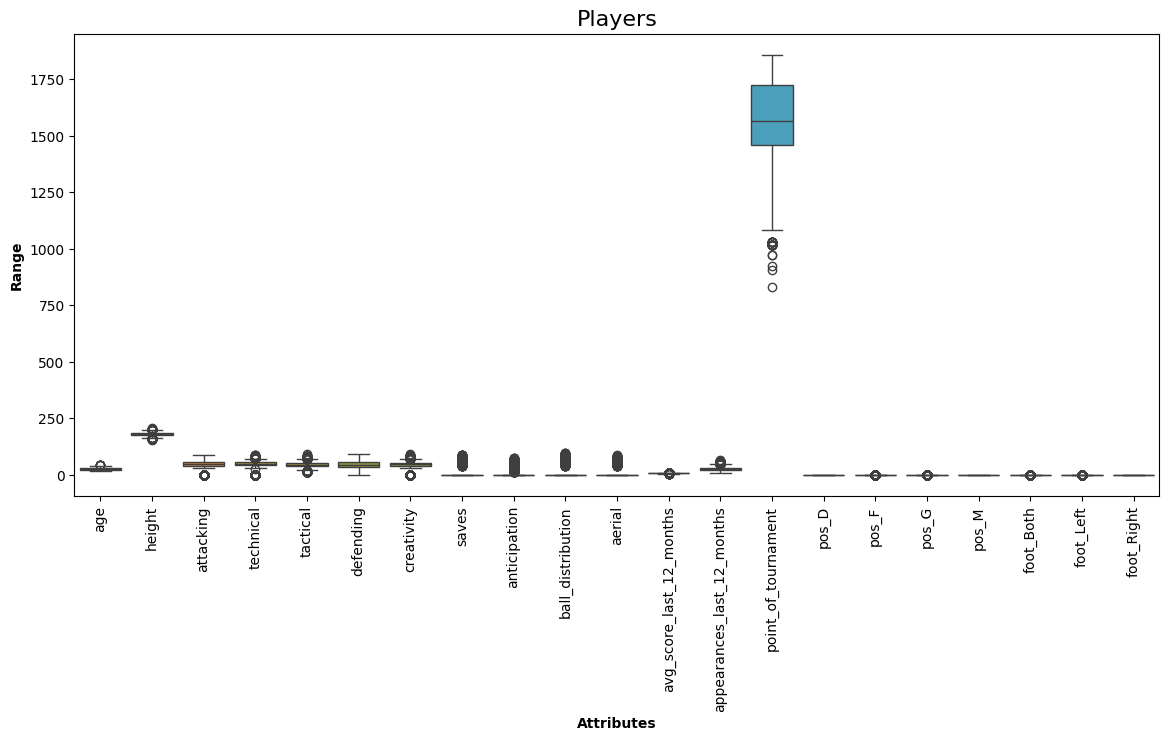

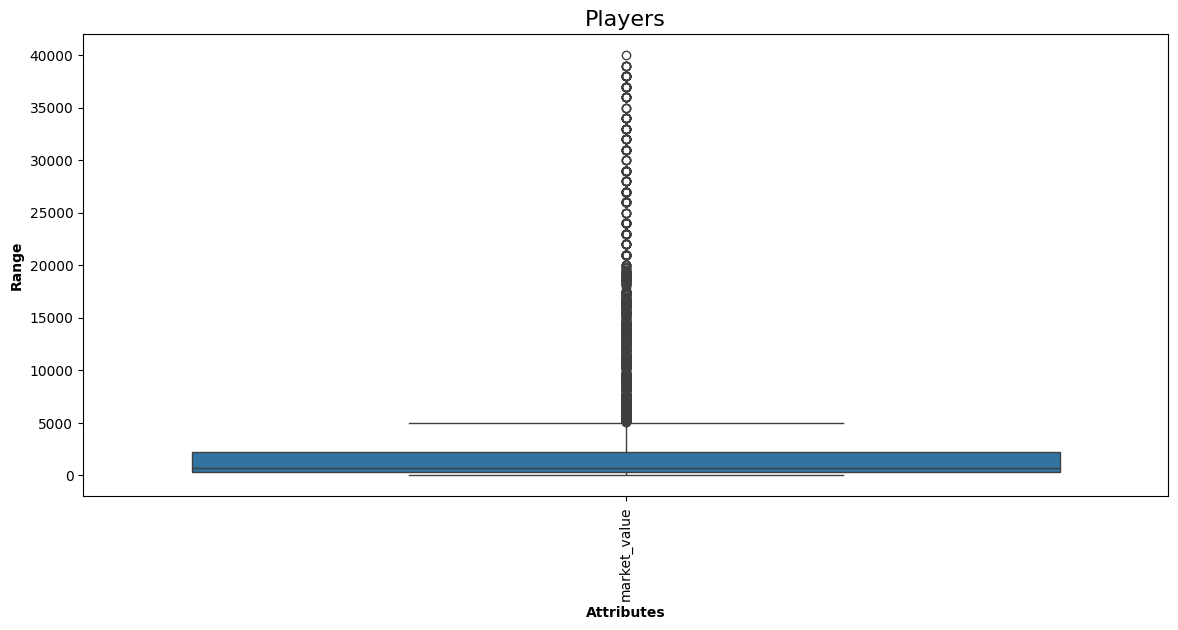

In [285]:
# Đồ thị trước khi xử lý ngoại lệ

players = players.select_dtypes(include=['float64', 'int64', 'int32', 'bool'])

def show_boxplot(df, title):
    plt.rcParams['figure.figsize'] = [14,6]
    sns.boxplot(data = df, orient="v")
    plt.title(title, fontsize = 16)
    plt.ylabel("Range", fontweight = 'bold')
    plt.xlabel("Attributes", fontweight = 'bold')
    plt.xticks(rotation=90)
    plt.show()
    
show_boxplot(players.drop(['market_value'], axis=1),"Players")
show_boxplot(players['market_value'].to_frame(),"Players")

C:\Users\tienn\AppData\Local\Temp\ipykernel_2244\1979265942.py:8: UserWarning:

Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.



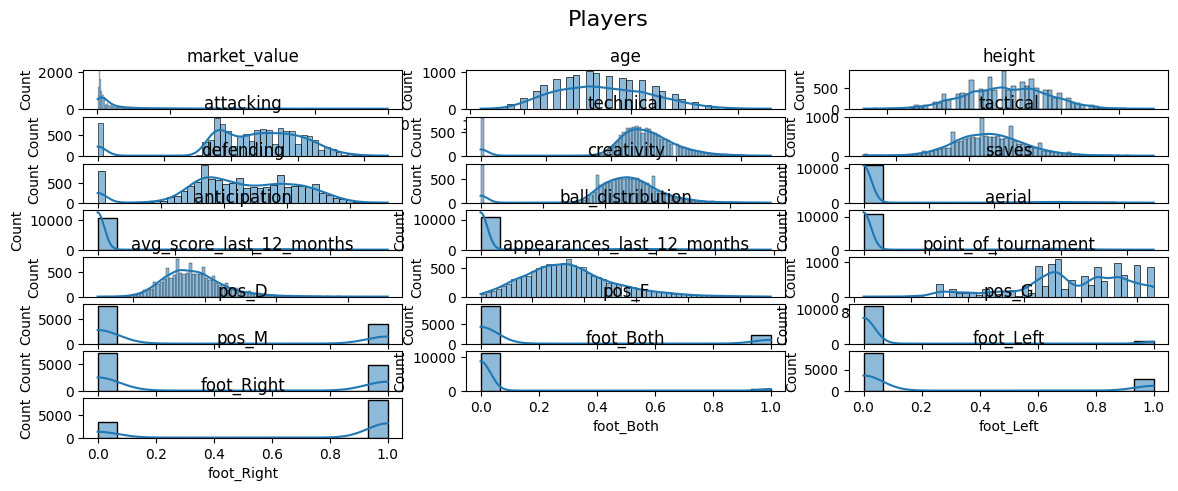

In [286]:
def show_histplot(df, title):
    plt.rcParams['figure.figsize'] = [14,6]
    for i, col in enumerate(df.columns):
        plt.subplot(10, 3, i+1)
        sns.histplot(df[col], kde=True)
        plt.title(col)
    plt.suptitle(title, fontsize = 16)
    plt.tight_layout()
    plt.show()

show_histplot(players, "Players")

#### Tiến hành chuẩn hóa dữ liệu

In [287]:
players_origin = players.copy()
players_origin.head(3)

market_value  age  height  attacking  technical  tactical  defending  \
0          7400   22     189         68         55        51         33   
1          2500   25     179         62         48        54         32   
2          1200   22     184         64         51        45         29   

   creativity  saves  anticipation  ...  avg_score_last_12_months  \
0          49      0             0  ...                      7.14   
1          47      0             0  ...                      6.86   
2          48      0             0  ...                      6.80   

   appearances_last_12_months  point_of_tournament  pos_D  pos_F  pos_G  \
0                          33               1858.0  False   True  False   
1                          37               1858.0  False   True  False   
2                          34               1858.0  False   True  False   

   pos_M  foot_Both  foot_Left  foot_Right  
0  False      False       True       False  
1  False      False      False        True  
2  False      False      False        True  

[3 rows x 22 columns]

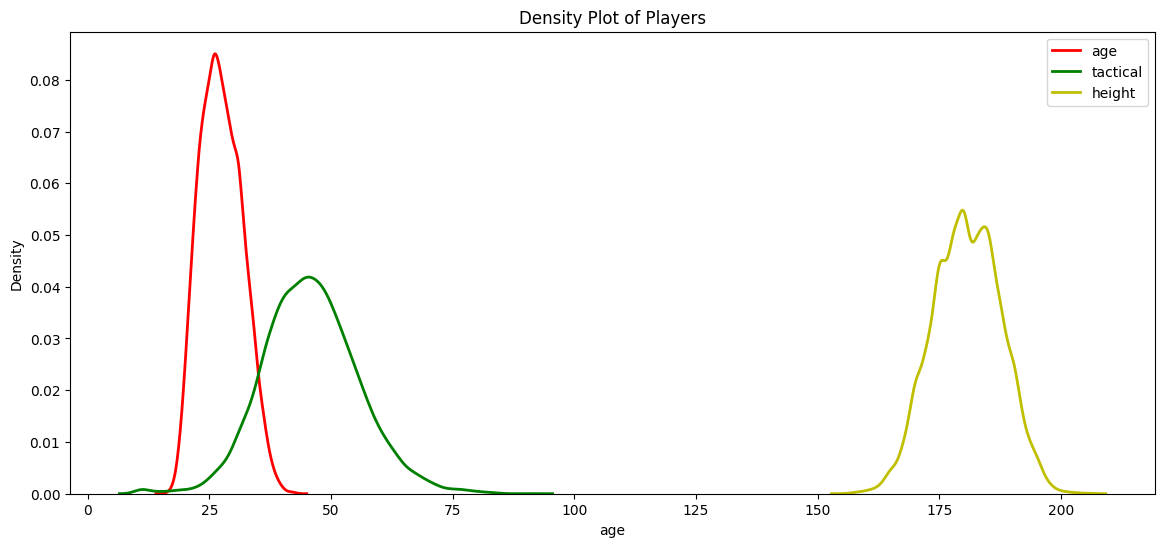

In [288]:
sns.kdeplot(players['age'], color ='r', linewidth=2)
sns.kdeplot(players['tactical'], color ='g', linewidth=2)
sns.kdeplot(players['height'], color ='y', linewidth=2)
plt.legend(['age', 'tactical', 'height'])
plt.title('Density Plot of Players')
plt.show()

In [289]:
min_max = StandardScaler()
players[['tactical', 'age', 'height']] = min_max.fit_transform(players[['tactical', 'age', 'height']])

In [290]:
players.head(3)

market_value       age    height  attacking  technical  tactical  \
0          7400 -1.249153  1.205285         68         55  0.525178   
1          2500 -0.556287 -0.238109         62         48  0.831075   
2          1200 -1.249153  0.483588         64         51 -0.086615   

   defending  creativity  saves  anticipation  ...  avg_score_last_12_months  \
0         33          49      0             0  ...                      7.14   
1         32          47      0             0  ...                      6.86   
2         29          48      0             0  ...                      6.80   

   appearances_last_12_months  point_of_tournament  pos_D  pos_F  pos_G  \
0                          33               1858.0  False   True  False   
1                          37               1858.0  False   True  False   
2                          34               1858.0  False   True  False   

   pos_M  foot_Both  foot_Left  foot_Right  
0  False      False       True       False  
1  False      False      False        True  
2  False      False      False        True  

[3 rows x 22 columns]

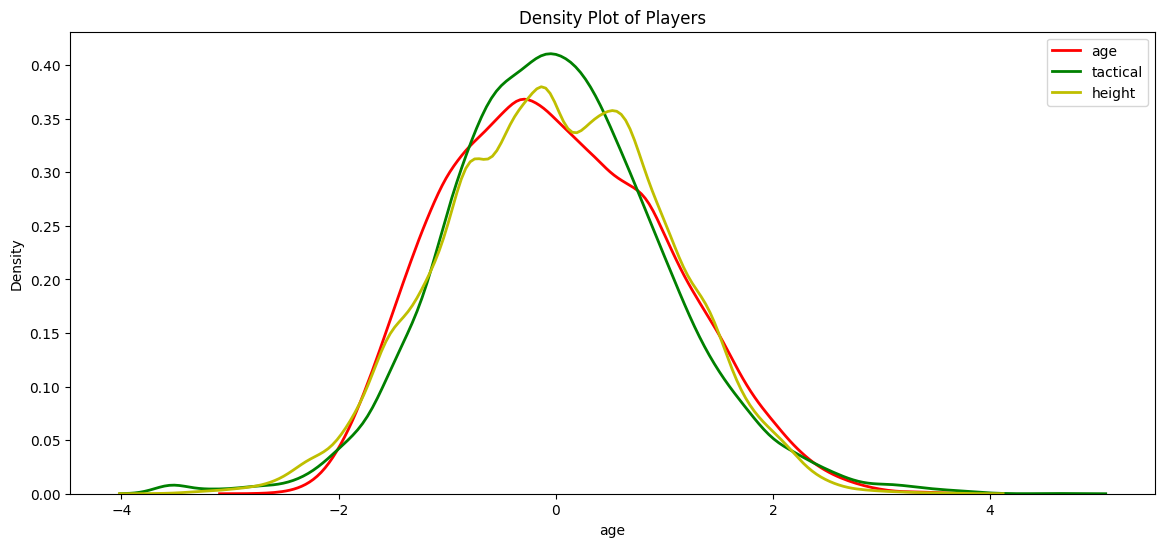

In [291]:
sns.kdeplot(players['age'], color ='r', linewidth=2)
sns.kdeplot(players['tactical'], color ='g', linewidth=2)
sns.kdeplot(players['height'], color ='y', linewidth=2)
plt.legend(['age', 'tactical', 'height'])
plt.title('Density Plot of Players')
plt.show()

In [292]:
min_max = MinMaxScaler()
players[['market_value', 'attacking', 'technical', 'defending', 'creativity', 'saves', 'anticipation', 'ball_distribution', 'aerial', 'avg_score_last_12_months', 'appearances_last_12_months', 'point_of_tournament']] = min_max.fit_transform(players[['market_value', 'attacking', 'technical', 'defending', 'creativity', 'saves', 'anticipation', 'ball_distribution', 'aerial', 'avg_score_last_12_months', 'appearances_last_12_months', 'point_of_tournament']])
players.head(3)

market_value       age    height  attacking  technical  tactical  \
0      0.184531 -1.249153  1.205285   0.781609   0.617978  0.525178   
1      0.061961 -0.556287 -0.238109   0.712644   0.539326  0.831075   
2      0.029442 -1.249153  0.483588   0.735632   0.573034 -0.086615   

   defending  creativity  saves  anticipation  ...  avg_score_last_12_months  \
0   0.358696    0.526882    0.0           0.0  ...                  0.438424   
1   0.347826    0.505376    0.0           0.0  ...                  0.300493   
2   0.315217    0.516129    0.0           0.0  ...                  0.270936   

   appearances_last_12_months  point_of_tournament  pos_D  pos_F  pos_G  \
0                    0.410714                  1.0  False   True  False   
1                    0.482143                  1.0  False   True  False   
2                    0.428571                  1.0  False   True  False   

   pos_M  foot_Both  foot_Left  foot_Right  
0  False      False       True       False  
1  False      False      False        True  
2  False      False      False        True  

[3 rows x 22 columns]

In [293]:
#min _max for all
min_max = MinMaxScaler()
players = pd.DataFrame(min_max.fit_transform(players), columns=players.columns)

players.head(3)

players_encoded = players.copy()

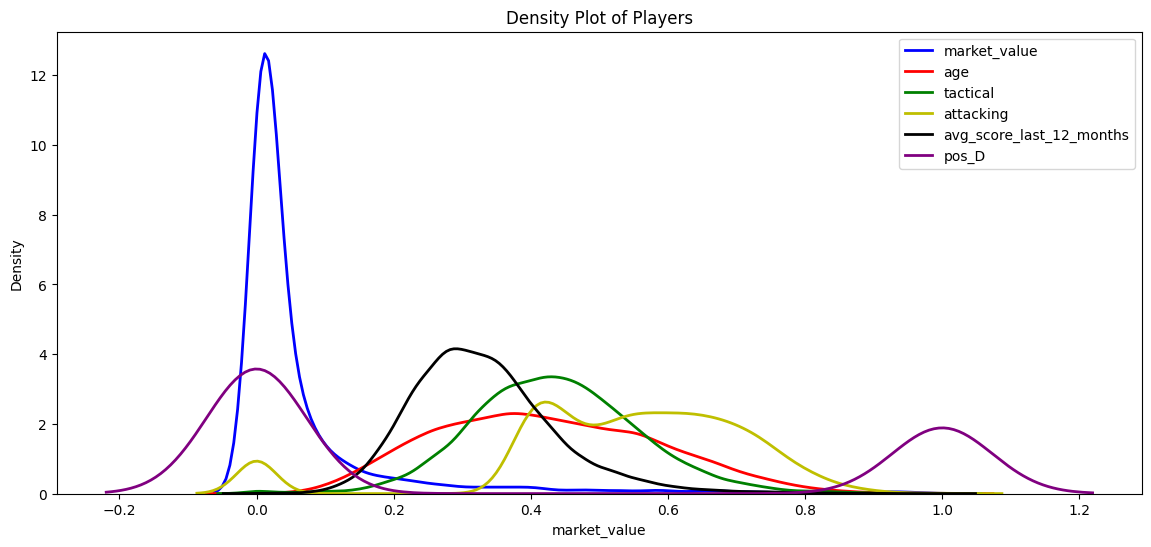

In [294]:
sns.kdeplot(players['market_value'], color ='b', linewidth=2)
sns.kdeplot(players['age'], color ='r', linewidth=2)
sns.kdeplot(players['tactical'], color ='g', linewidth=2)
sns.kdeplot(players['attacking'], color ='y', linewidth=2)
sns.kdeplot(players['avg_score_last_12_months'], color ='black', linewidth=2)
sns.kdeplot(players['pos_D'], color ='purple', linewidth=2)
plt.legend(['market_value', 'age', 'tactical', 'attacking', 'avg_score_last_12_months', 'pos_D'])
plt.title('Density Plot of Players')
plt.show()

#### Tiến hành lựa chọn đặc trưng

In [295]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.01):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

players = variance_threshold_selector(players)

players.head(3)

market_value       age  height  attacking  technical  tactical  defending  \
0      0.184531  0.222222    0.66   0.781609   0.617978    0.5000   0.358696   
1      0.061961  0.333333    0.46   0.712644   0.539326    0.5375   0.347826   
2      0.029442  0.222222    0.56   0.735632   0.573034    0.4250   0.315217   

   creativity  saves  anticipation  ...  avg_score_last_12_months  \
0    0.526882    0.0           0.0  ...                  0.438424   
1    0.505376    0.0           0.0  ...                  0.300493   
2    0.516129    0.0           0.0  ...                  0.270936   

   appearances_last_12_months  point_of_tournament  pos_D  pos_F  pos_G  \
0                    0.410714                  1.0    0.0    1.0    0.0   
1                    0.482143                  1.0    0.0    1.0    0.0   
2                    0.428571                  1.0    0.0    1.0    0.0   

   pos_M  foot_Both  foot_Left  foot_Right  
0    0.0        0.0        1.0         0.0  
1    0.0        0.0        0.0         1.0  
2    0.0        0.0        0.0         1.0  

[3 rows x 22 columns]

### Lựa chọn tham số

In [296]:
# Lựa chọn tham số perplexity

perplexity = np.arange(10, 110, 10)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, perplexity=i)
    reduced = model.fit_transform(players)
    divergence.append(model.kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

``Nhận xét``:
- Vì dữ liệu cầu thủ lớn, giá trị của các biến dữ liệu của các cầu thủ ít tách biệt và phân bố khá đều. Do đó, khi tăng **perplexity** thì độ phân kỳ KL giảm dần, nhưng làm giảm khả năng phân biệt các điểm dữ liệu tương tự.
- Lựa chọn tham số perplexity = 100 cho ra độ phân kỳ KL là 1.01 để dữ liệu trực quan cân bằng giữa việc trực quan hóa dữ liệu toàn cục mượt mà nhưng vẫn giữ được khả năng phân biệt giữa các điểm dữ liệu tương tự ở gần.

In [297]:
# Sử dụng T-SNE giảm chiều dữ liệu

players = players_encoded.copy()
tsne = TSNE(n_components=2, perplexity=100, random_state=42)
players_tsne = tsne.fit_transform(players)

tsne.kl_divergence_

1.2650885581970215

In [298]:
players_tsne_df = pd.DataFrame(players_tsne, columns=['x', 'y'])
px.scatter(players_tsne_df, x='x', y='y')

### **``3. Các mô hình phân cụm dữ liệu``**
--------

### ``A. Hierarchical Clustering``: phương pháp phân cụm phân cấp

- Ưu điểm: không yêu cầu khai báo trước số lượng cụm. Thay vào đó, thuật toán chỉ yêu cầu xác định trước thước đo về sự khác biệt giữa các cụm (không giao nhau), dựa trên sự khác biệt từng cặp giữa các quan sát trong hai cụm.
- Biểu diễn phân cấp theo đồ thị dendrogram 

![markdown](https://imgur.com/aJhvsa8.png)

- Đây là 1 dạng của ``cây quyết định nhị phân``
- Chia thành 2 chiến lược : ``Hợp nhất (agglomerative)`` và ``phân chia (divisive)``

##### ``Cây quyết định nhị phân``

- Cây quyết định nhị phân là một mô hình học máy sử dụng cấu trúc dạng cây để phân loại dữ liệu. Cây được tạo thành từ các nút (node) và nhánh (branch). Mỗi nút đại diện cho một câu hỏi hoặc quyết định, và mỗi nhánh đại diện cho một câu trả lời hoặc kết quả có thể xảy ra.
- Nhị phân -> mỗi nút chỉ có 2 nhánh con (tương ứng với true / false)

##### ``Chiến lược hợp nhất ``

- Đi từ ``dưới`` lên ``trên``, bắt đầu ở các ``nút lá``
- Ban đầu ``mỗi quan sát`` được xem là ``1 cụm tách biệt``
- Ở mỗi level, tìm cách hợp 1 cặp cụm thành 1 cụm duy nhất cho level cao hơn
- Cụm mới này tương ứng với các node quyết định (non-leaf node)
- 1 cặp đc chọn để hợp nhất là những cụm trung gian không giao nhau 


![markdown](https://imgur.com/SWdmUac.png)


*Các bước xác định:*
- Bước 1: Gán mỗi quan sát là 1 cụm 
- Bước 2: Gộp 2 cụm có khoảng cách gần nhất lại thành 1 cụm (sử dụng Euclidian cho điểm, khoảng cách trung bình cho cụm)
- Lặp lại cho đến khi chỉ còn 1 cụm chứa hết tất cả

*Có 4 cách để xác định khoảng cách giữa các cụm:*
- Ward linkage: đo khoảng cách giữa 2 tâm cụm
- Sinlge linkage: cặp điểm gần nhất của 2 cụm
- Complete linkage: cặp điểm xa nhất của 2 cụm
- Group average: trung bình toàn bộ khoảng cách giữa các cặp điểm từ 2 cụm

##### ``Chiến lược phân chia``

- Chiều ngược lại, từ trên xuống
- Tại mỗi level ta phân chia đệ quy thành 2 cụm mới sao cho có sự tách biệt nhau lớn nhất 

![markdown](https://imgur.com/SWdmUac.png)

### **``Áp dụng``**
--------

Text(0, 0.5, 'dissimilarity metric cluster')

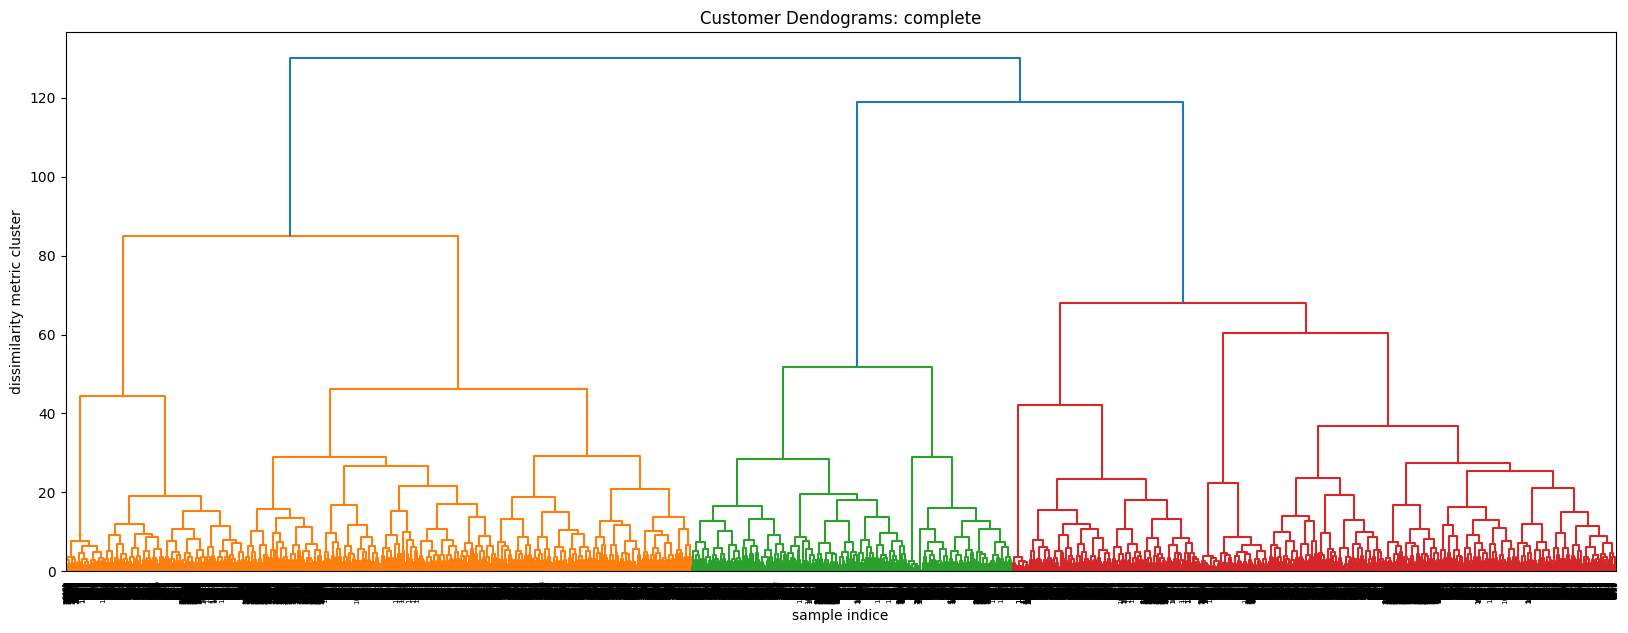

In [299]:
# Đồ thị Dendograms sử dụng phương pháp: Complete-linkage

plt.figure(figsize=(20, 7))
plt.title("Customer Dendograms: complete")
dend = shc.dendrogram(shc.linkage(players_tsne, method='complete'))
# plt.axhline(65, linestyle='--')
plt.xlabel('sample indice')
plt.ylabel('dissimilarity metric cluster')

Text(0, 0.5, 'dissimilarity metric cluster')

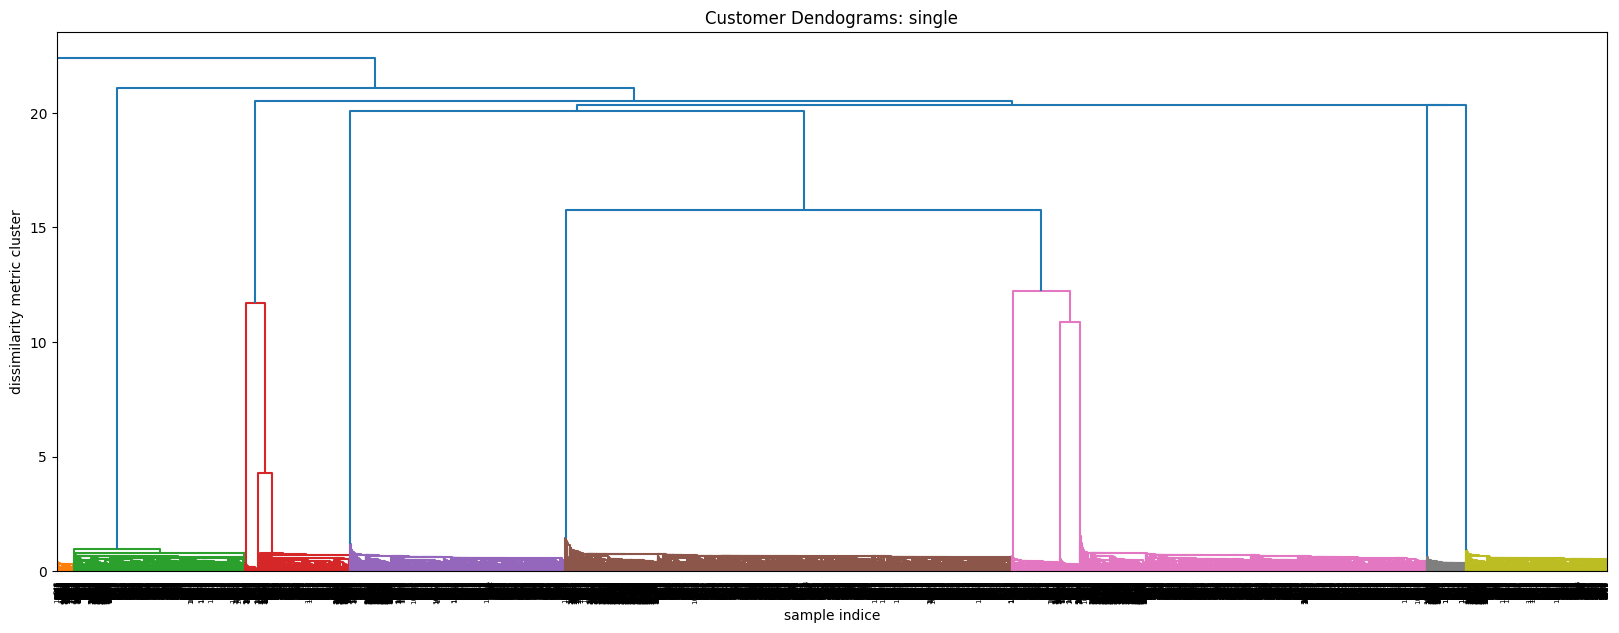

In [300]:
# Đồ thị Dendograms sử dụng phương pháp: Single-linkage


plt.figure(figsize=(20, 7))
plt.title("Customer Dendograms: single")
dend = shc.dendrogram(shc.linkage(players_tsne, method='single'))
# plt.axhline(65, linestyle='--')
plt.xlabel('sample indice')
plt.ylabel('dissimilarity metric cluster')

Text(0, 0.5, 'dissimilarity metric cluster')

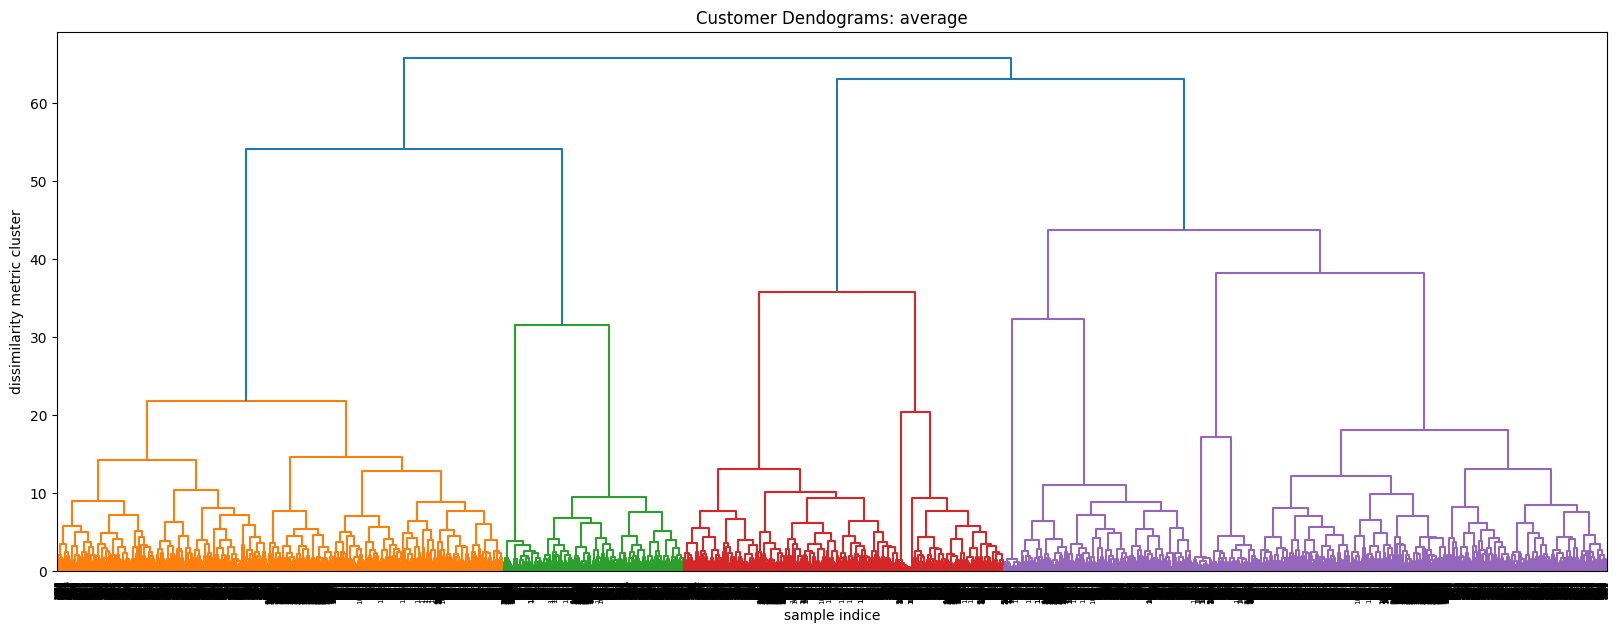

In [301]:
# Đồ thị Dendograms sử dụng phương pháp: Group-average

plt.figure(figsize=(20, 7))
plt.title("Customer Dendograms: average")
dend = shc.dendrogram(shc.linkage(players_tsne, method='average'))
# plt.axhline(19, linestyle='--')
plt.xlabel('sample indice')
plt.ylabel('dissimilarity metric cluster')

Text(0, 0.5, 'dissimilarity metric cluster')

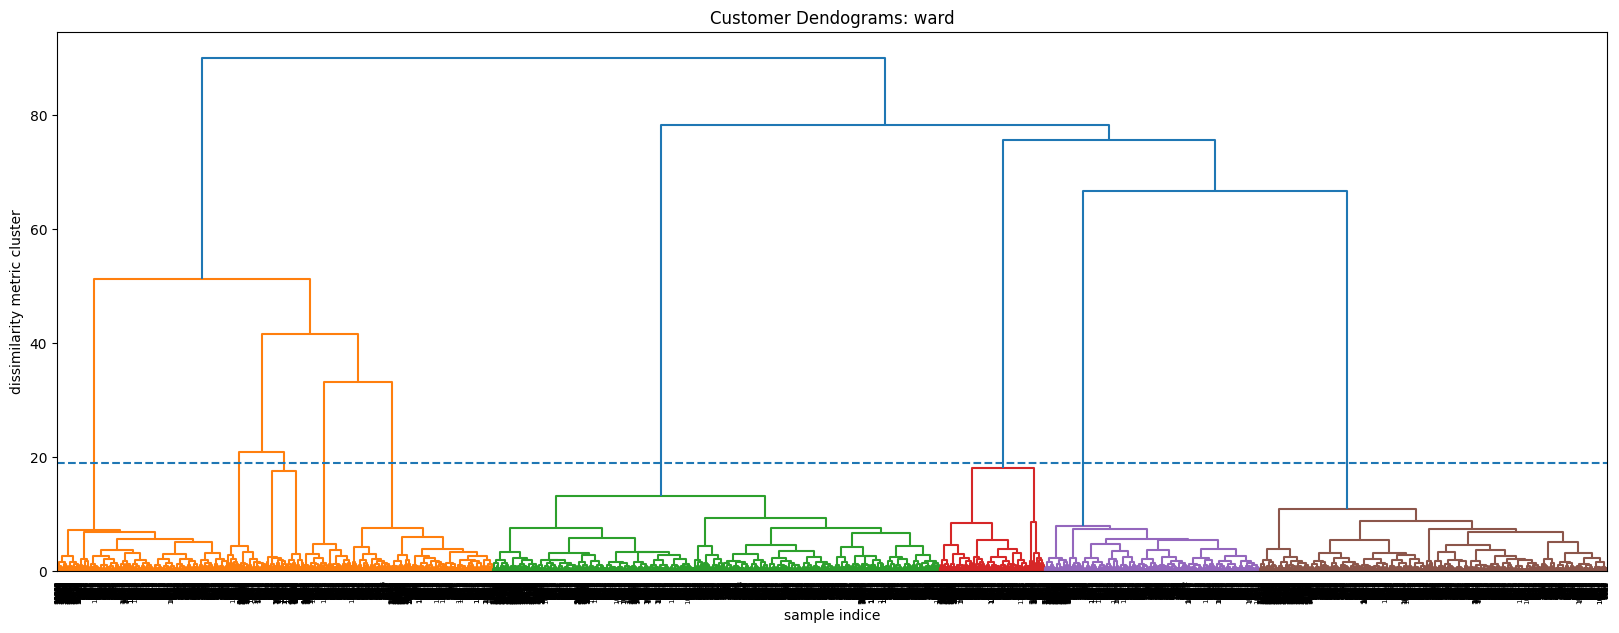

In [302]:
# Đồ thị Dendograms sử dụng phương pháp: Ward-linkage

plt.figure(figsize=(20, 7))
plt.title("Customer Dendograms: ward")
dend = shc.dendrogram(shc.linkage(players, method='ward'))
plt.axhline(19, linestyle='--')
plt.xlabel('sample indice')
plt.ylabel('dissimilarity metric cluster')

## Chọn thước đo về sự khác biệt giữa các cụm là 12, Với phương pháp Ward-linkage xác định được 9 cụm.

In [303]:
# Gom nhóm dữ liệu theo số lượng cụm đã chọn và theo từng phương pháp đo khoảng cách

cluster = AgglomerativeClustering(n_clusters=9, linkage='complete')
labels_com = cluster.fit_predict(players)

cluster = AgglomerativeClustering(n_clusters=9, linkage='single')
labels_sing = cluster.fit_predict(players)

cluster = AgglomerativeClustering(n_clusters=9, linkage='average')
labels_aver = cluster.fit_predict(players)

cluster = AgglomerativeClustering(n_clusters=9, linkage='ward')
labels_ward = cluster.fit_predict(players)

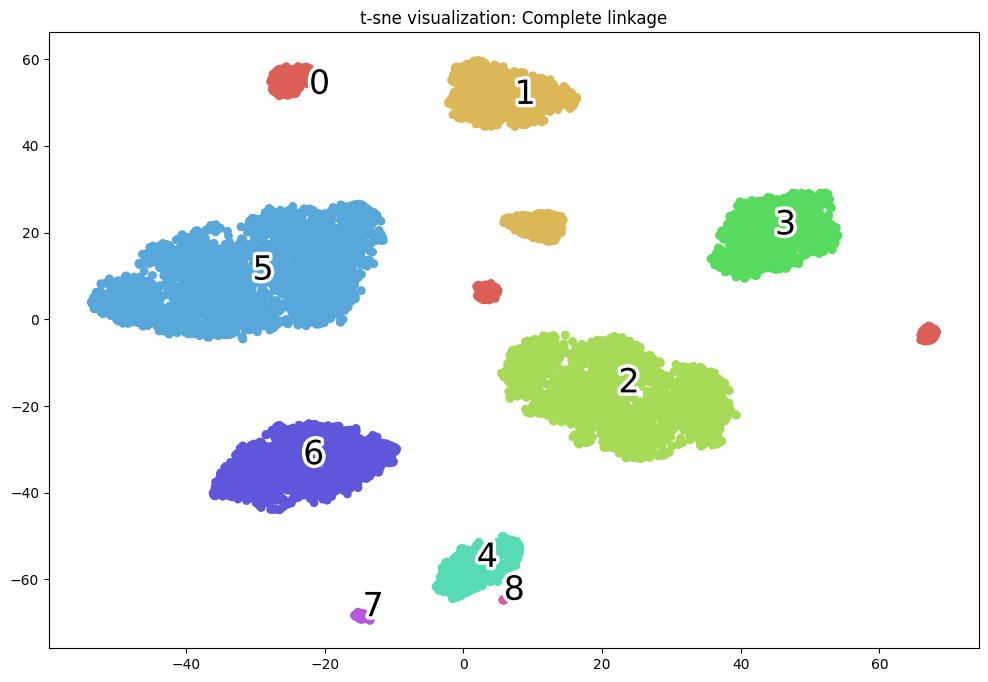

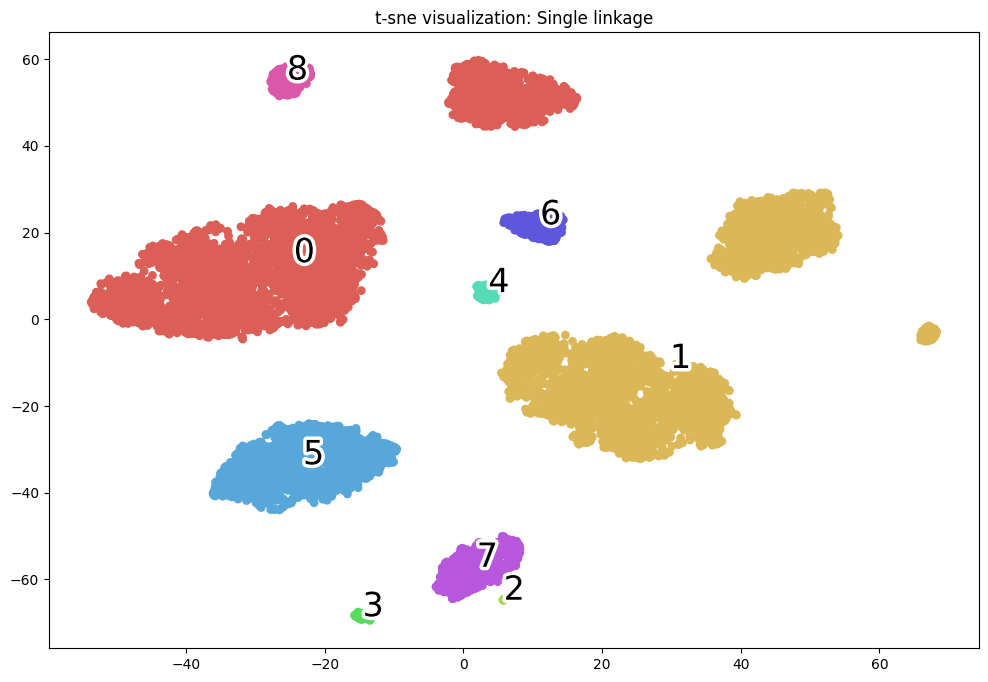

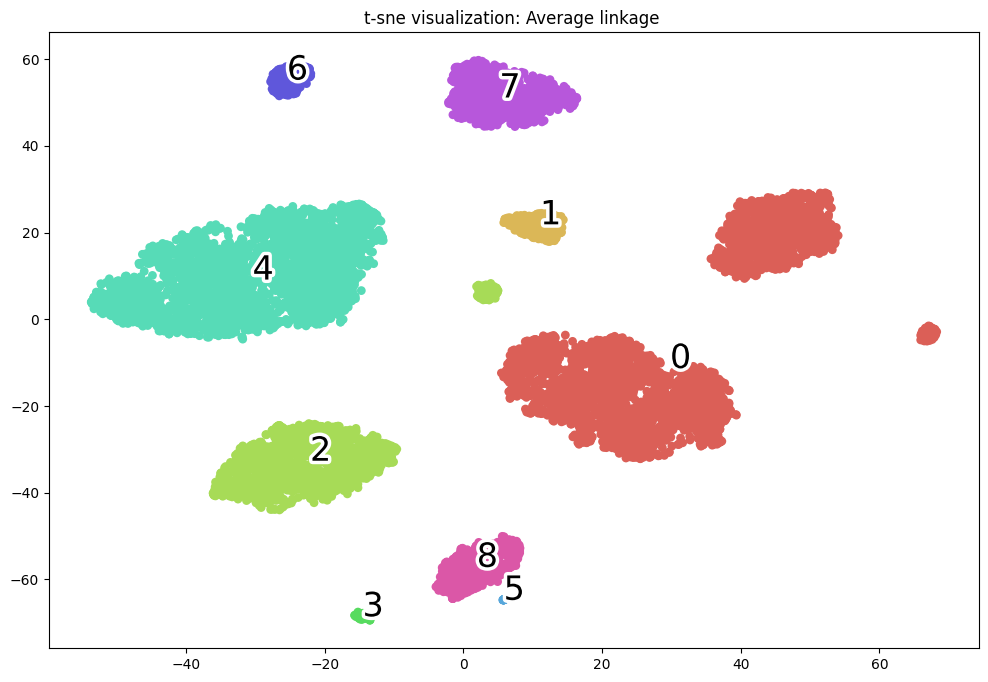

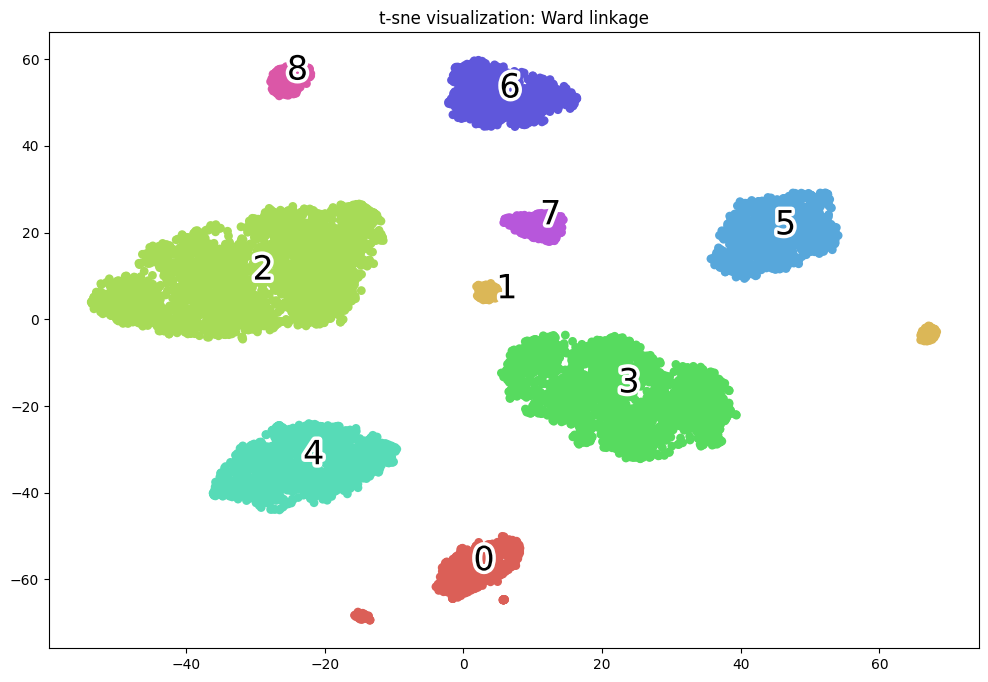

In [304]:
# Vẽ các đồ thị biểu diễn sự phân cụm theo từng phương pháp đo khoảng cách

def _plot_kmean_scatter(X, labels, title):
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot()
    sc = ax.scatter(X[:,0], X[:,1], lw=0, s=40, c=palette[labels.astype(int)])
    txts = []
    for i in range(num_classes):
        xtext, ytext = np.median(X[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.title('t-sne visualization: '+title)    

_plot_kmean_scatter(players_tsne, labels_com, "Complete linkage")
_plot_kmean_scatter(players_tsne, labels_sing, "Single linkage")
_plot_kmean_scatter(players_tsne, labels_aver, "Average linkage ")
_plot_kmean_scatter(players_tsne, labels_ward, "Ward linkage")

``Nhận xét``:
- 3 phương pháp biểu diễn phân cấp **complete linkage, average linkage, ward linkage** đều thể hiện được sự phân cấp dữ liệu
- Phương pháp **Complete linkage** và **Single linkage** (tính khoảng cách của cặp điểm xa nhất và gần nhất) tạo ra cụm có hình dạng trải dài ảnh hưởng của việc tính khoảng cách của cụm theo cặp điểm xa nhất hoặc gần nhất. Vì vậy 2 phương pháp này sẽ bị ảnh hưởng nhiều bởi các ngoại lệ, và tạo ra cụm trải dài khiến cho đặc trưng giữa các cụm không quá rõ ràng.
- Phương pháp **Group average** lấy trung bình toàn bộ khoảng cách giữa các điểm. Vì vậy nó sẽ khá giống với 2 phương pháp **Complete linkage** và **Single linkage**
- Phương pháp **Ward linkage** là phương pháp phương sai nội cụm tối thiểu (minimum variance). Nó nhằm giảm thiểu phương sai bên trong các cụm, do đó tạo ra các cụm có hình dạng gần với hình cầu và kích thước tương đương nhau. Từ đó sẽ dễ quan sát, khảo sát được tính chất các cụm tốt hơn.
- **Do đó sẽ chọn phương pháp Ward linkage để sử dụng**

#### ``Khảo sát tính chất từng cụm``

In [305]:
# Gán nhãn cụm cho dữ liệu ban đầu 

# players_with_labels = players_origin.copy()
players_with_labels = players_origin.copy()
players_with_labels['cluster'] = labels_ward

In [306]:
players_with_labels['cluster'].value_counts()

cluster
2    3358
3    2607
4    1617
5    1285
6    1059
0     789
7     361
8     294
1     281
Name: count, dtype: int64

In [307]:
players_with_labels.head(3)

market_value  age  height  attacking  technical  tactical  defending  \
0          7400   22     189         68         55        51         33   
1          2500   25     179         62         48        54         32   
2          1200   22     184         64         51        45         29   

   creativity  saves  anticipation  ...  appearances_last_12_months  \
0          49      0             0  ...                          33   
1          47      0             0  ...                          37   
2          48      0             0  ...                          34   

   point_of_tournament  pos_D  pos_F  pos_G  pos_M  foot_Both  foot_Left  \
0               1858.0  False   True  False  False      False       True   
1               1858.0  False   True  False  False      False      False   
2               1858.0  False   True  False  False      False      False   

   foot_Right  cluster  
0       False        7  
1        True        4  
2        True        4  

[3 rows x 23 columns]

In [308]:
# write to csv
players_with_labels.to_csv('./players_with_labels.csv', index=False)

In [309]:
players_original_with_labels = players_with_labels.copy()

In [310]:
# Tạo các players theo cụm

player_cluster_0 = players_original_with_labels[players_original_with_labels['cluster'] == 0]
player_cluster_1 = players_original_with_labels[players_original_with_labels['cluster'] == 1]
player_cluster_2 = players_original_with_labels[players_original_with_labels['cluster'] == 2]
player_cluster_3 = players_original_with_labels[players_original_with_labels['cluster'] == 3]
player_cluster_4 = players_original_with_labels[players_original_with_labels['cluster'] == 4]
player_cluster_5 = players_original_with_labels[players_original_with_labels['cluster'] == 5]
player_cluster_6 = players_original_with_labels[players_original_with_labels['cluster'] == 6]
player_cluster_7 = players_original_with_labels[players_original_with_labels['cluster'] == 7]
player_cluster_8 = players_original_with_labels[players_original_with_labels['cluster'] == 8]

In [311]:
# Dữ liệu cho các cluster
clusters = [player_cluster_0, player_cluster_1, player_cluster_2, player_cluster_3, player_cluster_4, 
            player_cluster_5, player_cluster_6, player_cluster_7, player_cluster_8]
# Dữ liệu cho các cluster độ cao
clusters_height = [player_cluster_0['height'], player_cluster_1['height'], player_cluster_2['height'], 
                   player_cluster_3['height'], player_cluster_4['height'], player_cluster_5['height'], 
                   player_cluster_6['height'], player_cluster_7['height'], player_cluster_8['height']]
# Dữ liệu cho các cluster độ tuổi
clusters_age = [player_cluster_0['age'], player_cluster_1['age'], player_cluster_2['age'], 
                   player_cluster_3['age'], player_cluster_4['age'], player_cluster_5['age'], 
                   player_cluster_6['age'], player_cluster_7['age'], player_cluster_8['age']]
# Dữ liệu cho các cluster điểm số trung bình
clusters_scores = [player_cluster_0['avg_score_last_12_months'], player_cluster_1['avg_score_last_12_months'], player_cluster_2['avg_score_last_12_months'], 
                   player_cluster_3['avg_score_last_12_months'], player_cluster_4['avg_score_last_12_months'], player_cluster_5['avg_score_last_12_months'], 
                   player_cluster_6['avg_score_last_12_months'], player_cluster_7['avg_score_last_12_months'], player_cluster_8['avg_score_last_12_months']]
# Dữ liệu cho các cluster điểm số trung bình
clusters_marketvalue = [player_cluster_0['market_value'], player_cluster_1['market_value'], player_cluster_2['market_value'], 
                        player_cluster_3['market_value'], player_cluster_4['market_value'], player_cluster_5['market_value'], 
                        player_cluster_6['market_value'], player_cluster_7['market_value'], player_cluster_8['market_value']]
# Dữ liệu cho các cluster số lần xuất hiện
clusters_appearances_last_12_months = [player_cluster_0['appearances_last_12_months'], player_cluster_1['appearances_last_12_months'], player_cluster_2['appearances_last_12_months'], 
                   player_cluster_3['appearances_last_12_months'], player_cluster_4['appearances_last_12_months'], player_cluster_5['appearances_last_12_months'], 
                   player_cluster_6['appearances_last_12_months'], player_cluster_7['appearances_last_12_months'], player_cluster_8['appearances_last_12_months']]
# Dữ liệu cho các cluster: giá trị thị trường 
clusters_market_value = [player_cluster_0['market_value'], player_cluster_1['market_value'], player_cluster_2['market_value'], 
                   player_cluster_3['market_value'], player_cluster_4['market_value'], player_cluster_5['market_value'], 
                   player_cluster_6['market_value'], player_cluster_7['market_value'], player_cluster_8['market_value']]
# Dữ liệu cho các cluster : các chỉ số
clusters_attacking = [player_cluster_0['attacking'], player_cluster_1['attacking'], player_cluster_2['attacking'], 
                   player_cluster_3['attacking'], player_cluster_4['attacking'], player_cluster_5['attacking'], 
                   player_cluster_6['attacking'], player_cluster_7['attacking'], player_cluster_8['attacking']]
clusters_technical = [player_cluster_0['technical'], player_cluster_1['technical'], player_cluster_2['technical'], 
                   player_cluster_3['technical'], player_cluster_4['technical'], player_cluster_5['technical'], 
                   player_cluster_6['technical'], player_cluster_7['technical'], player_cluster_8['technical']]
clusters_tactical = [player_cluster_0['tactical'], player_cluster_1['tactical'], player_cluster_2['tactical'], 
                   player_cluster_3['tactical'], player_cluster_4['tactical'], player_cluster_5['tactical'], 
                   player_cluster_6['tactical'], player_cluster_7['tactical'], player_cluster_8['tactical']]
clusters_defending = [player_cluster_0['defending'], player_cluster_1['defending'], player_cluster_2['defending'], 
                   player_cluster_3['defending'], player_cluster_4['defending'], player_cluster_5['defending'], 
                   player_cluster_6['defending'], player_cluster_7['defending'], player_cluster_8['defending']]
clusters_creativity = [player_cluster_0['creativity'], player_cluster_1['creativity'], player_cluster_2['creativity'], 
                   player_cluster_3['creativity'], player_cluster_4['creativity'], player_cluster_5['creativity'], 
                   player_cluster_6['creativity'], player_cluster_7['creativity'], player_cluster_8['creativity']]
clusters_saves = [player_cluster_0['saves'], player_cluster_1['saves'], player_cluster_2['saves'], 
                   player_cluster_3['saves'], player_cluster_4['saves'], player_cluster_5['saves'], 
                   player_cluster_6['saves'], player_cluster_7['saves'], player_cluster_8['saves']]
clusters_anticipation = [player_cluster_0['anticipation'], player_cluster_1['anticipation'], player_cluster_2['anticipation'], 
                   player_cluster_3['anticipation'], player_cluster_4['anticipation'], player_cluster_5['anticipation'], 
                   player_cluster_6['anticipation'], player_cluster_7['anticipation'], player_cluster_8['anticipation']]
clusters_ball_distribution = [player_cluster_0['ball_distribution'], player_cluster_1['ball_distribution'], player_cluster_2['ball_distribution'], 
                   player_cluster_3['ball_distribution'], player_cluster_4['ball_distribution'], player_cluster_5['ball_distribution'], 
                   player_cluster_6['ball_distribution'], player_cluster_7['ball_distribution'], player_cluster_8['ball_distribution']]
clusters_aerial = [player_cluster_0['aerial'], player_cluster_1['aerial'], player_cluster_2['aerial'], 
                   player_cluster_3['aerial'], player_cluster_4['aerial'], player_cluster_5['aerial'], 
                   player_cluster_6['aerial'], player_cluster_7['aerial'], player_cluster_8['aerial']]
clusters_point_of_tournament = [player_cluster_0['point_of_tournament'], player_cluster_1['point_of_tournament'], player_cluster_2['point_of_tournament'], 
                   player_cluster_3['point_of_tournament'], player_cluster_4['point_of_tournament'], player_cluster_5['point_of_tournament'], 
                   player_cluster_6['point_of_tournament'], player_cluster_7['point_of_tournament'], player_cluster_8['point_of_tournament']]
# -----------------------------------------------------------------
# -----------------------------------------------------------------
# -----------------------------------------------------------------
# Màu sắc cho các boxplot của từng cluster độ cao
box_colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightpink', 'lightyellow', 'lightblue', 'lightgreen', 'lightcoral']

``Khảo sát các vị trí đá của cầu thủ trong các cụm``

In [312]:
# cluster_data.head()
players_original_with_labels.head()

market_value  age  height  attacking  technical  tactical  defending  \
0          7400   22     189         68         55        51         33   
1          2500   25     179         62         48        54         32   
2          1200   22     184         64         51        45         29   
3          2900   22     182         58         60        47         38   
4          1200   28     187         55         50        41         33   

   creativity  saves  anticipation  ...  appearances_last_12_months  \
0          49      0             0  ...                          33   
1          47      0             0  ...                          37   
2          48      0             0  ...                          34   
3          59      0             0  ...                          37   
4          44      0             0  ...                          38   

   point_of_tournament  pos_D  pos_F  pos_G  pos_M  foot_Both  foot_Left  \
0               1858.0  False   True  False  False      False       True   
1               1858.0  False   True  False  False      False      False   
2               1858.0  False   True  False  False      False      False   
3               1858.0  False  False  False   True      False       True   
4               1858.0  False  False  False   True      False      False   

   foot_Right  cluster  
0       False        7  
1        True        4  
2        True        4  
3       False        6  
4        True        2  

[5 rows x 23 columns]

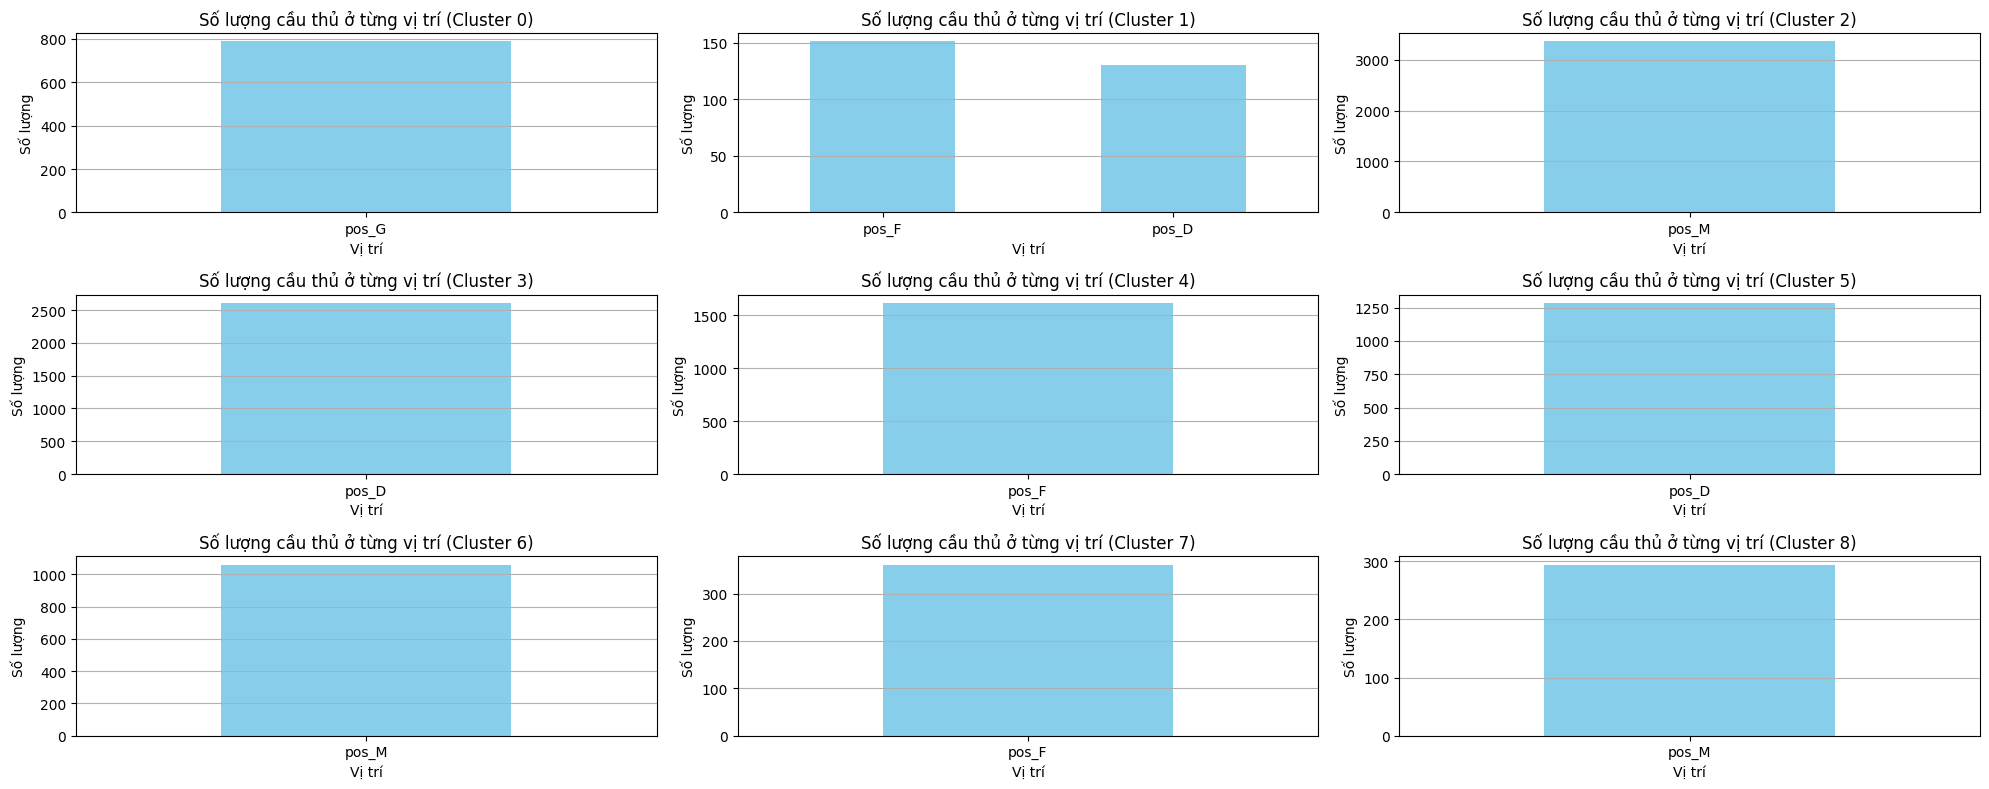

In [313]:
# Khảo sát vị trí đá trong các cụm
plt.figure(figsize=(20, 8))
for i, cluster_data in enumerate(clusters):
    positions = cluster_data[['pos_D', 'pos_F', 'pos_G', 'pos_M']].idxmax(axis=1)
    position_counts = positions.value_counts()
    plt.subplot(3, 3, i+1)
    position_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
    plt.xlabel('Vị trí')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

**Nhận xét:**
- Cụm 0: có duy nhất vị trí cầu thủ là Thủ môn(G)
- Cụm 2, 6, 8: có duy nhất vị trí cầu thủ là Tiền vệ(M)
- Cụm 3, 5: có duy nhất vị trí cầu thù là Hậu vệ(D)
- Cụm 4, 7: có duy nhất vị trí cầu thủ là Tiền đạo(F)
- Cụm 1: có 2 vị trí cầu thù là Tiền đạo(F) và Hậu về(D).

``Khảo sát theo (độ tuổi, chiều cao, điểm số trung bình và số lần xuất hiện 12 tháng gần nhất, hệ số giải đấu)``

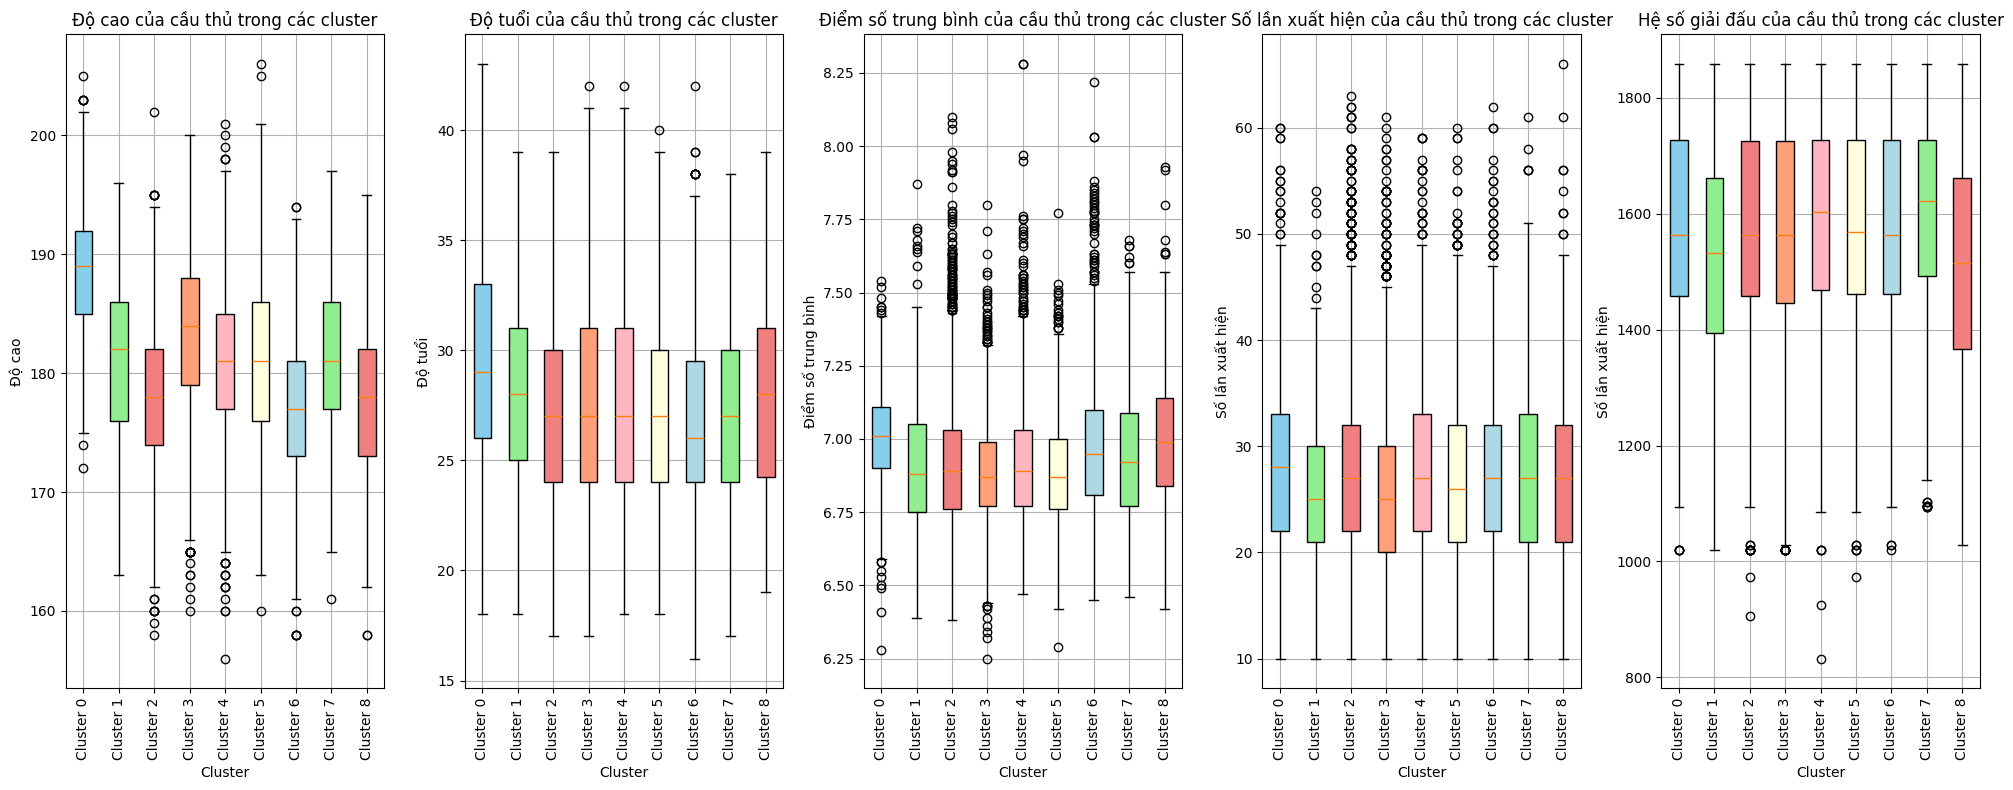

In [314]:
plt.figure(figsize=(20, 8))
# for i, cluster_data in enumerate(clusters):
#     positions = cluster_data['position']
#     position_counts = positions.value_counts()

#     plt.subplot(3, 5, i+1)
#     position_counts.plot(kind='bar', color='skyblue')
#     plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
#     plt.xlabel('Vị trí')
#     plt.ylabel('Số lượng')
#     plt.xticks(rotation=0)
#     plt.grid(axis='y')


# -----------------------------------------------------------------
# Biểu đồ boxplot cho độ cao
plt.subplot(1, 5, 1)
boxplot_height = plt.boxplot(clusters_height, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Độ cao của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Độ cao')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho độ tuôi
plt.subplot(1, 5, 2)
boxplot_height = plt.boxplot(clusters_age, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Độ tuổi của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Độ tuổi')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho điểm số trung bình
plt.subplot(1, 5, 3)
boxplot_scores = plt.boxplot(clusters_scores, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 
        'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_scores['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Điểm số trung bình của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Điểm số trung bình')
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho số lần xuất hiện
plt.subplot(1, 5, 4)
boxplot_height = plt.boxplot(clusters_appearances_last_12_months, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Số lần xuất hiện của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Số lần xuất hiện')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho hệ số giải đấu
plt.subplot(1, 5, 5)
boxplot_height = plt.boxplot(clusters_point_of_tournament, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Hệ số giải đấu của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Số lần xuất hiện')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()


**Nhận xét:**
- Các cụm về Hậu về (D): Hậu vệ trong cụm 3 và 5 có các thông số khá tương đồng nhau. Tuy nhiên ở cụm 3 thì các Hậu vệ chiều cao cao hơn, độ tuổi trải dài hơn so với cụm 5.
- Cụm về Tiền đạo(F): Tiền đạo trong các cụm 4, 7 có các chỉ số khá tương đồng nhau. Cụm 4 sẽ là các tiền đạo có độ tuổi trẻ hơn.
    + Tiền đạo/Hậu vệ ở cụm 1 có độ tuổi lớn, có các chỉ số ở mức trung bình, thi đấu ít và thường tham gia các giải đấu nhỏ
- Các cụm về Tiền vệ(M): 
    + Tiền vệ trong các cụm 2, 6, 8 có các chỉ số khá tương đồng nhau
    + Khác biệt là tiền vệ trong cụm 2, 6 là các tiền vệ thi đấu trong các giải lớn và tần suất ra sân cao, Tiền vệ trong cụm 8 là các giải hệ số nhỏ và không thường xuyên ra sân
    + Khác biệt là tiền vệ trong cụm 2, 6 là các tiền vệ có độ tuổi trẻ, trong cụm 2 là các tiền vệ có điểm số trung bình thấp và trong cụm 8 là các tiền vệ tham gia thi đấu trong các giải đấu thấp.
- Cụm về Thủ môn(G): Cụm 0 là cụm chỉ riêng Thủ môn mang rõ đặc trưng của vai trò thủ môn khi có Chiều cao và độ tuổi trung bình lớn

``Khảo sát theo các chỉ số (9 chỉ số)``

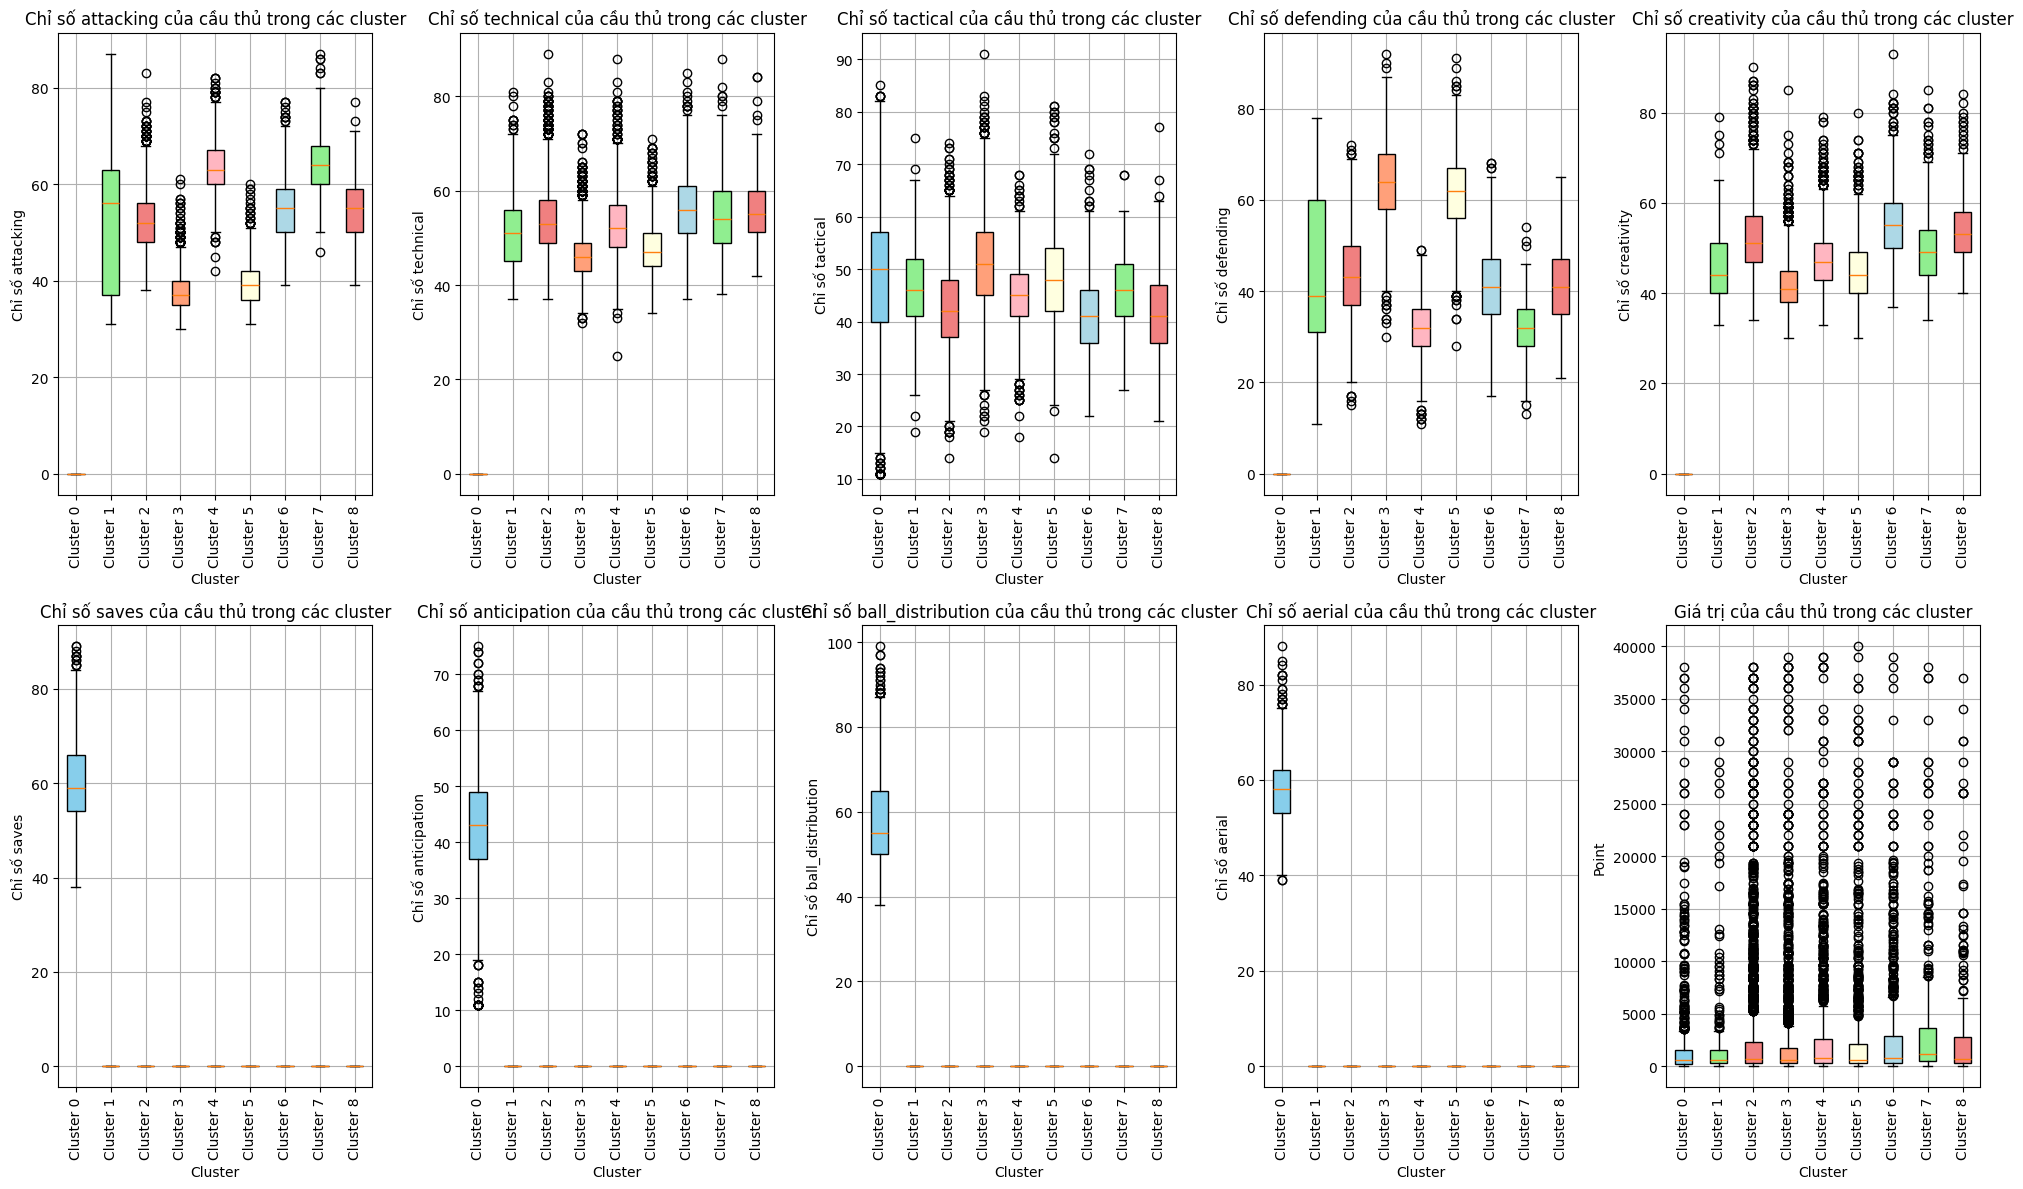

In [315]:
plt.figure(figsize=(20, 12))

# for i, cluster_data in enumerate(clusters):
#     positions = cluster_data['position']
#     position_counts = positions.value_counts()
#     plt.subplot(4, 5, i+1)
#     position_counts.plot(kind='bar', color='skyblue')
#     plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
#     plt.xlabel('Vị trí')
#     plt.ylabel('Số lượng')
#     plt.xticks(rotation=0)
#     plt.grid(axis='y')


# -----------------------------------------------------------------
# Biểu đồ boxplot cho attacking
plt.subplot(2, 5, 1)
boxplot_height = plt.boxplot(clusters_attacking, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số attacking của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số attacking')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho technical
plt.subplot(2, 5, 2)
boxplot_height = plt.boxplot(clusters_technical, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số technical của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số technical')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho tactical
plt.subplot(2, 5, 3)
boxplot_height = plt.boxplot(clusters_tactical, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số tactical của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số tactical')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho defending
plt.subplot(2, 5, 4)
boxplot_height = plt.boxplot(clusters_defending, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số defending của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số defending')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho creativity
plt.subplot(2, 5, 5)
boxplot_height = plt.boxplot(clusters_creativity, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số creativity của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số creativity')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho saves
plt.subplot(2, 5, 6)
boxplot_height = plt.boxplot(clusters_saves, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số saves của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số saves')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho anticipation
plt.subplot(2, 5, 7)
boxplot_height = plt.boxplot(clusters_anticipation, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số anticipation của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số anticipation')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho ball_distribution
plt.subplot(2, 5, 8)
boxplot_height = plt.boxplot(clusters_ball_distribution, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số ball_distribution của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số ball_distribution')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho aerial
plt.subplot(2, 5, 9)
boxplot_height = plt.boxplot(clusters_aerial, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số aerial của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số aerial')
plt.xticks(rotation=90)
plt.grid(True)
# -----------------------------------------------------------------
# Biểu đồ boxplot cho market value
plt.subplot(2, 5, 10)
boxplot_height = plt.boxplot(clusters_market_value, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Giá trị của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Point')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()

**Nhận xét:**

- Các cụm về Hậu về (D):
    + Hậu vệ trong cụm 1 sẽ có các chỉ số attacking, tenhnical, creaitivity cao hơn hẳn so với cụm 3, 5. Tuy nhiên chỉ số defending lại thấp hơn rõ rệt.
    + Hậu vệ trong cụm 3, 5 thì lại khá tương đồng với nhau. Tuy nhiên ở cụm 3 thì lại nhỉnh hơn về chỉ số tactical, defending, còn lại các chỉ số khác thì hậu vệ ở cụm 5 sẽ nhỉnh hơn.


- Cụm về Tiền đạo(F): Tiền đạo trong cụm 1 sẽ có chỉ số attacking thấp hơn hẳn và chỉ số  defending sẽ cao rõ rệt hơn so với 2 cụm 4,7. Còn lại các chỉ số khác thì Tiền đạo trong các cụm có chỉ số khá tương đồng nhau, cụm 7 sẽ nhỉnh hơn 1 chút so với các cụm còn lại.


- Các cụm về Tiền vệ(M): Tiền vệ trong cụm 2 có chỉ số defending khá cao và chỉ số attacking, technical, creativity sẽ thấp hơn so với 2 cụm còn lại. Đối với cụm 6, 8 thì các chỉ số của tiền vệ khá tương đồng với nhau.


- Cụm về Thủ môn(G): Cụm 0, thủ môn là nhóm có Tactical cao, sự chỉ số giữa các thủ môn trong cụm là không quá tách biệt

``Khảo sát theo chân đá``

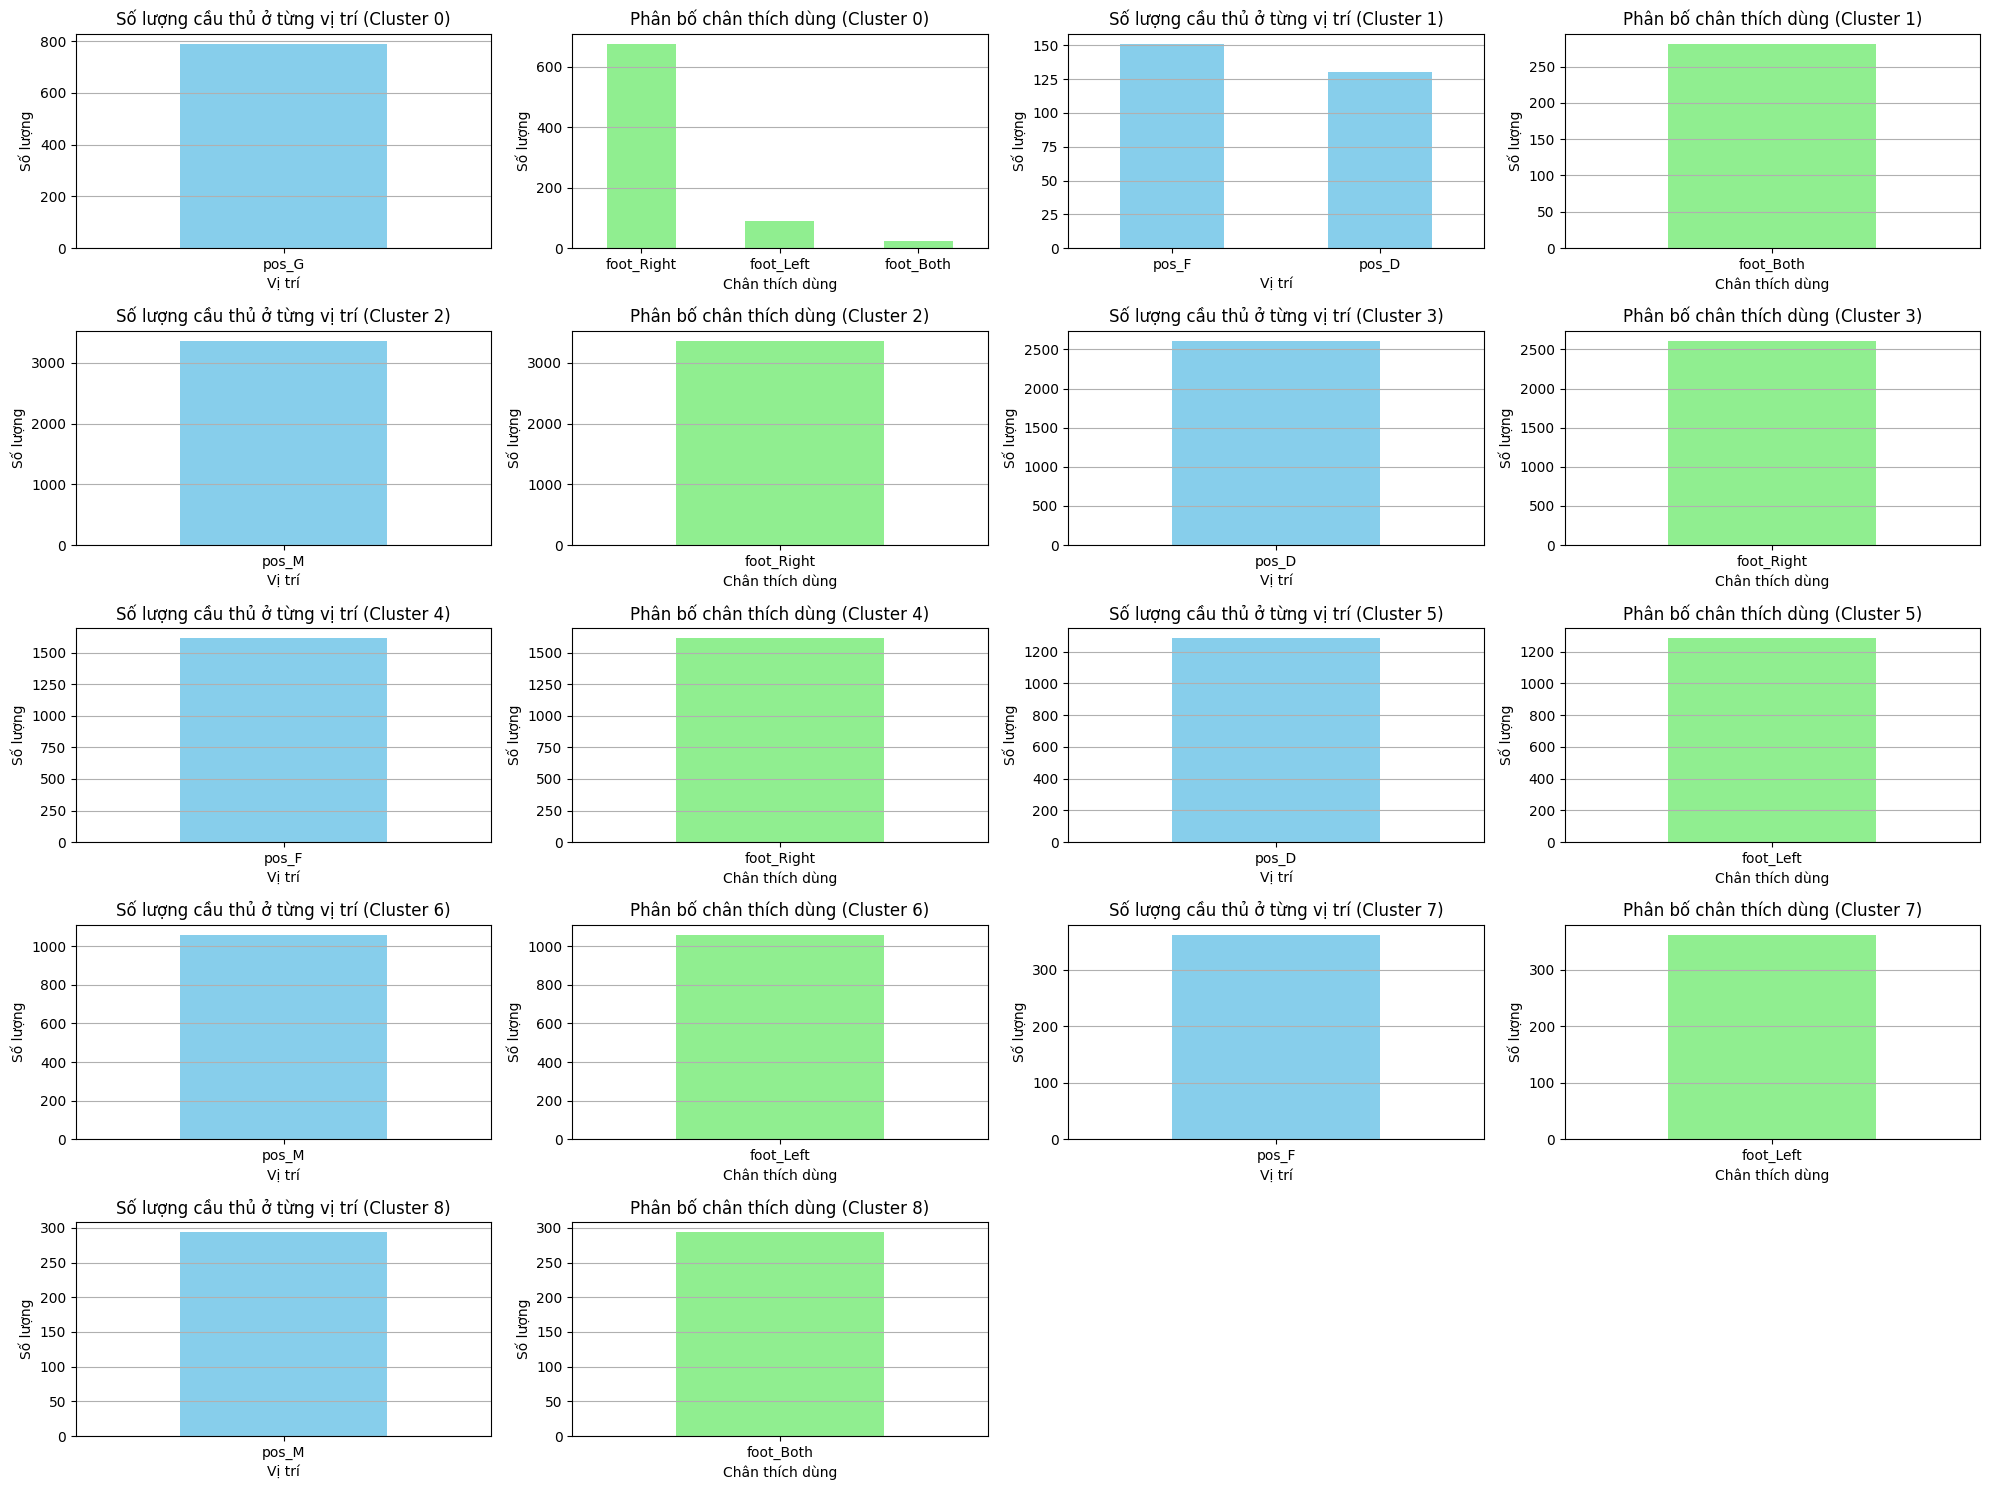

In [316]:
# Khảo sát chân thuận các cầu thủ trong các cụm

plt.figure(figsize=(20, 15))

# for i, cluster_data in enumerate(clusters):
#     positions = cluster_data[['pos_D', 'pos_F', 'pos_G', 'pos_M']].idxmax(axis=1)
#     position_counts = positions.value_counts()
#     plt.subplot(3, 3, i+1)
#     position_counts.plot(kind='bar', color='skyblue')
#     plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
#     plt.xlabel('Vị trí')
#     plt.ylabel('Số lượng')
#     plt.xticks(rotation=0)
#     plt.grid(axis='y')

for i, cluster_data in enumerate(clusters):
    positions = cluster_data[['pos_D', 'pos_F', 'pos_G', 'pos_M']].idxmax(axis=1)
    preferred_foot = cluster_data[['foot_Left', 'foot_Right', 'foot_Both']].idxmax(axis=1)
    position_counts = positions.value_counts()
    foot_counts = preferred_foot.value_counts()

    # Biểu đồ số lượng cầu thủ ở từng vị trí
    plt.subplot(5, 4, (2 * i) + 1)
    position_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
    plt.xlabel('Vị trí')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

    # Biểu đồ phân bố chân thích dùng
    plt.subplot(5, 4, (2 * i) + 2)
    foot_counts.plot(kind='bar', color='lightgreen')
    plt.title(f'Phân bố chân thích dùng (Cluster {i})')
    plt.xlabel('Chân thích dùng')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

**Nhận xét:**
- Các cụm về Hậu về (D):
    + Hậu vệ trong cụm 3 sẽ có sở trường là chân phải.
    + Hậu vệ trong cụm 5 thì lại có sở trường là chân trái.
- Cụm về Tiền đạo(F):
    + Tiền đạo trong cụm 4 sở trường đá chân Phải.
    + Tiền đạo cụm 1 có thể sử dụng cả 2 chân.
    + Tiền đạo cụm 7 sẽ sử dụng chân trái.
- Các cụm về Tiền vệ(M): 
    + Tiền vệ trong cụm 2 có sở trường là chân phải.
    + Tiền vệ trong cụm 6 thì lại có sở trường chân trái.
    + Tiền vệ trong cụm 8 thì sẽ có thể đá ở cả 2 chân.
- Cụm về Thủ môn(G): Thủ môn hầu hết sở trường chân phải, số ít sở trường chân Trái và cả 2.

``Khảo sát theo giá trị thị trường``

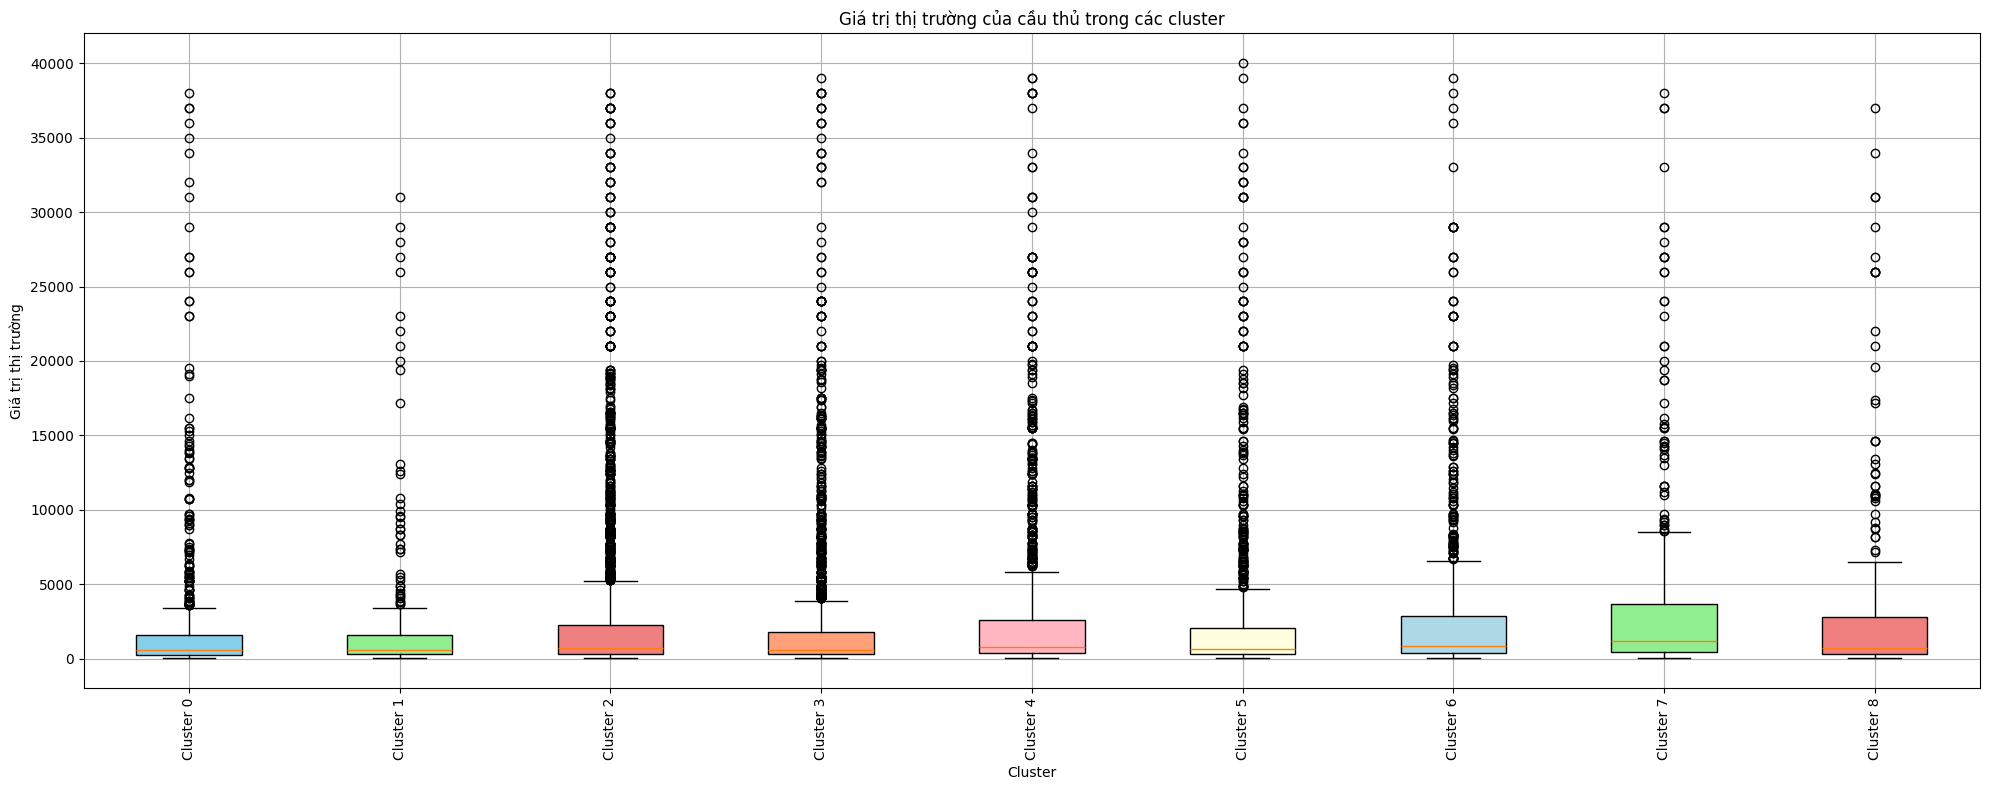

In [317]:
plt.figure(figsize=(20, 8))

# for i, cluster_data in enumerate(clusters):
#     positions = cluster_data['position']
#     position_counts = positions.value_counts()

#     plt.subplot(2, 5, i+1)
#     position_counts.plot(kind='bar', color='skyblue')
#     plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
#     plt.xlabel('Vị trí')
#     plt.ylabel('Số lượng')
#     plt.xticks(rotation=0)
#     plt.grid(axis='y')

# -----------------------------------------------------------------
# Biểu đồ boxplot cho giá trị thị trường 
# plt.subplot(1, 1, 1)
boxplot_height = plt.boxplot(clusters_market_value, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Giá trị thị trường của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Giá trị thị trường')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()


**Nhận xét:**
- Các cụm về Hậu về (D):
    + Hậu vệ cụm 3, 5 có giá trị thị trường trung bình cao hơn so với cụm 1
- Cụm về Tiền đạo(F): 
    + Tiền đạo cụm 4 với các chỉ số cao tương đối toàn diện nên có giá trị thị trường ở mức cao.
    + Tiền đạo ở cụm 7 và cụm 1 có giá trị trung bình cao và trung bình thấp
- Các cụm về Tiền vệ(M):
    + Tiền vệ ở cụm 2 và 6 có giá trị thị trường trùng bình cao
    + Tiền vệ cụm 8 có giá trị thấp
- Cụm về Thủ môn(G): Thủ môn có giá trị ở mức trung bình thấp

### Đánh giá kết quả phân cụm

In [318]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
davies_hierarchical = davies_bouldin_score(players_encoded, labels_ward)
calinski_hierarchical = calinski_harabasz_score(players_encoded, labels_ward)
ssilhouette_hierarchical = silhouette_score(players_encoded, labels_ward)

print(f'Davies Bouldin Score (lower is better): {davies_hierarchical}')
print(f'Calinski Harabasz Score (higher is better): {calinski_hierarchical}')
print(f'Silhouette Score (higher is better): {ssilhouette_hierarchical}')

Davies Bouldin Score (lower is better): 0.7749688721811813
Calinski Harabasz Score (higher is better): 9543.944992161687
Silhouette Score (higher is better): 0.6351066147314666


**``Nhận xét``**
- Phương pháp phân cụm phân cấp **Hierarchical Clustering** cho ra kết quả các cụm có tính chất và phân bố khác nhau tùy theo phương pháp đo khoảng cách giữa 2 cụm và lựa chọn thước đo về sự khác biệt giữa các cụm 
- **Hierarchical Clustering** cho ra kết quả phân cụm thể hiển tốt mỗi quan hệ giữa các cụm.
- Các cụm thu được:
    + Cụm 0: Là Thủ môn, cao, lớn tuổi, tactical cao, chân phải|số ít chân trái hoặc cả 2 chân, giá trị trung bình thấp
    + Cụm 1: Là Tiền đạo/Hậu vệ, attacking|technical|creativity cao, defending|tactical thấp, thuận 2 chân, lớn tuổi, giá trị trung bình thấp, giải đấu nhỏ
    + Cụm 2: Là Tiền vệ, hay ra sân, giải đấu lớn, defending|tactical khá cao, chân phải, giá trị trung bình cao
    + Cụm 3: Là Hậu vệ, khá lớn tuổi, hay ra sân, defending|tactical trung bình cao, giải đấu lớn,chân phải, giá trị trung bình cao
    + Cụm 4: Là Tiền đạo, attacking|technical|creativity trung bình cao, chân phải, giá trị cao
    + Cụm 5: Là Hậu vệ, trẻ, hay ra sân, attacking|technical|creativity trung bình cao, giải đấu lớn, chân trái, giá trị trunh bình cao
    + Cụm 6: Là Tiền vệ, hay ra sân, giải đấu lớn, attacking|technical|creativity trung bình, chân trái, giá trị trung bình cao
    + Cụm 7: Là Tiền đạo, attacking|technical|creativity trung bình cao, chân trái, giá trị trung bình
    + Cụm 8: Là Tiền vệ, ít ra sân, attacking|technical|creativity trung bình, giải đấu nhỏ, thuận 2 chân, giá trị thấp

### ``B. DBSCAN``: kĩ thuật phân cụm dựa trên mật độ (Density-Based Clustering)

Cốt lõi phương pháp:
- Phương pháp học không giám sát nhằm xác định các cụm phân biệt trong phân phối của dữ liệu
- Ý tưởng: một cụm trong không gian dữ liệu là một vùng có mật độ điểm cao được ngăn cách với các cụm khác bằng các vùng liền kề có mật độ điểm thấp.
- DBSCAN là một thuật toán cơ sở để phân nhóm dựa trên mật độ. Nó có thể phát hiện ra các cụm có hình dạng và kích thước khác nhau từ một lượng lớn dữ liệu chứa nhiễu.

##### ``Ưu điểm``
- Phân cụm theo mật độ (bỏ qua các outlier, không làm biến dạng cụm)
- Tìm được các điểm không thuộc bất kỳ cụm nào
- Không cần biết trước số cụm
##### ``Nhược điểm``
- Phải tìm đc epsilon
- Không phù hợp với bài toán mà kiểu dữ liệu thưa thớt hay tập dữ liệu phân bố không đồng đều

##### ``Các định nghĩa, tham số chính``
- Epsilon: là giá trị khoảng cách được sử dụng để xác định vùng lân cận epsilon của bất kỳ điểm dữ liệu nào. Giá trị của epsilon được chọn bằng biểu đồ k-distance, epsilon đạt giá trị tốt nhất tại elbow point.
- MinPts: Là số điểm tối thiểu để nhóm lại với nhau nhằm xác định vùng lân cận epsilon.
    + MinPts >= D + 1(D là số chiều của tập dữ liệu). Thường chọn min_points = 2 x D (nhiễu càng nhiều thì MinPts càng lớn)
##### ``Phân loại dạng điểm trong DBSCAN``
- Core point: là một điểm có ít nhất minPts trong vùng lân cận epsilon của nó.
- Border point: là một điểm có ít nhất một core point trong vùng lân cận epsilon nhưng mật độ không đủ minPts điểm.
- Noise point: là điểm không phải core point hay border point.
##### ``Thuật toán``
- Bước 1
    + Xác định các core point và border point của tập dữ liệu. 
- Bước 2:
    + Chọn ngẫu nhiên core point (không nằm trong cụm nào cả) gán vào 1 cụm.
    + Tìm các điểm lân cận của core point. 
        * Nếu điểm đó là core point thì thêm vào cụm, tiếp tục mở rộng cụm từ core point này. 
        * Nếu điểm đó là border point thì thêm vào cụm nhưng không mở rộng cụm từ điểm này  
- Bước 3:
    + Lặp lại đệ qui toàn bộ quá trình để xác định một cụm mới. 

### **``Áp dụng``**
--------

In [319]:
players = players_encoded.copy()

## Xác định các tham số

In [320]:
neighbors = 44

Text(0.5, 1.0, 'Sorting Maximum Distance in k Nearest Neighbor of kNN')

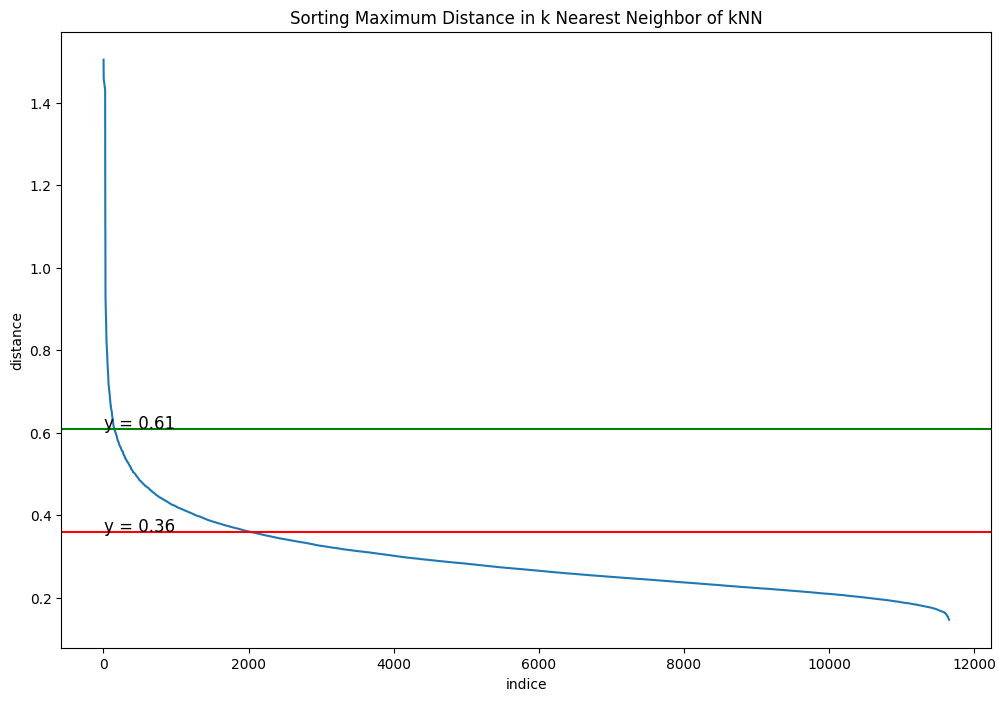

In [321]:
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(players)

# Ma trận khoảng cách distances: (N, k)
distances, indices = nbrs.kneighbors(players)

# Lấy ra khoảng cách xa nhất từ phạm vi láng giềng của mỗi điểm và sắp xếp theo thứ tự giảm dần.
distance_desc = sorted(distances[:, neighbors-1], reverse=True)

# Vẽ biểu đồ khoảng cách xa nhất ở trên theo thứ tự giảm dần
plt.figure(figsize=(12, 8))
plt.plot(list(range(1,len(distance_desc )+1)), distance_desc)
plt.axhline(y=0.36,color='red')
plt.text(2, 0.36, 'y = 0.36',fontsize=12)
plt.axhline(y=0.61, color='green')
plt.text(2, 0.61, 'y = 0.61', fontsize=12)
plt.ylabel('distance')
plt.xlabel('indice')
plt.title('Sorting Maximum Distance in k Nearest Neighbor of kNN')

## Hàm plot kết quả phân cụm

In [322]:
def _plot_kmean_scatter(X, labels, gs, thres): 
    # lựa chọn màu sắc
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", num_classes))

    # vẽ biểu đồ scatter
    ax = plt.subplot(gs)
    sc = ax.scatter(X[:,0], X[:,1], c=palette[labels.astype(np.int64)])

    # thêm nhãn cho mỗi cluster
    txts = []

    for i in range(num_classes):
        # Vẽ text tên cụm tại trung vị của mỗi cụm
        indices = (labels == i)
        xtext, ytext = np.median(X[indices, :], axis=0)
        if not (np.isnan(xtext) or np.isnan(ytext)):        
            txt = ax.text(xtext, ytext, str(i), fontsize=24) 
            txts.append(txt)
    plt.title('t-sne visualization for thres={:.4f}'.format(thres))

### Khảo sát các eps giúp xác định các điểm nằm trong vùng lân cận epsilon

11 11 11 12 12 12 12 12 12 12 12 12 

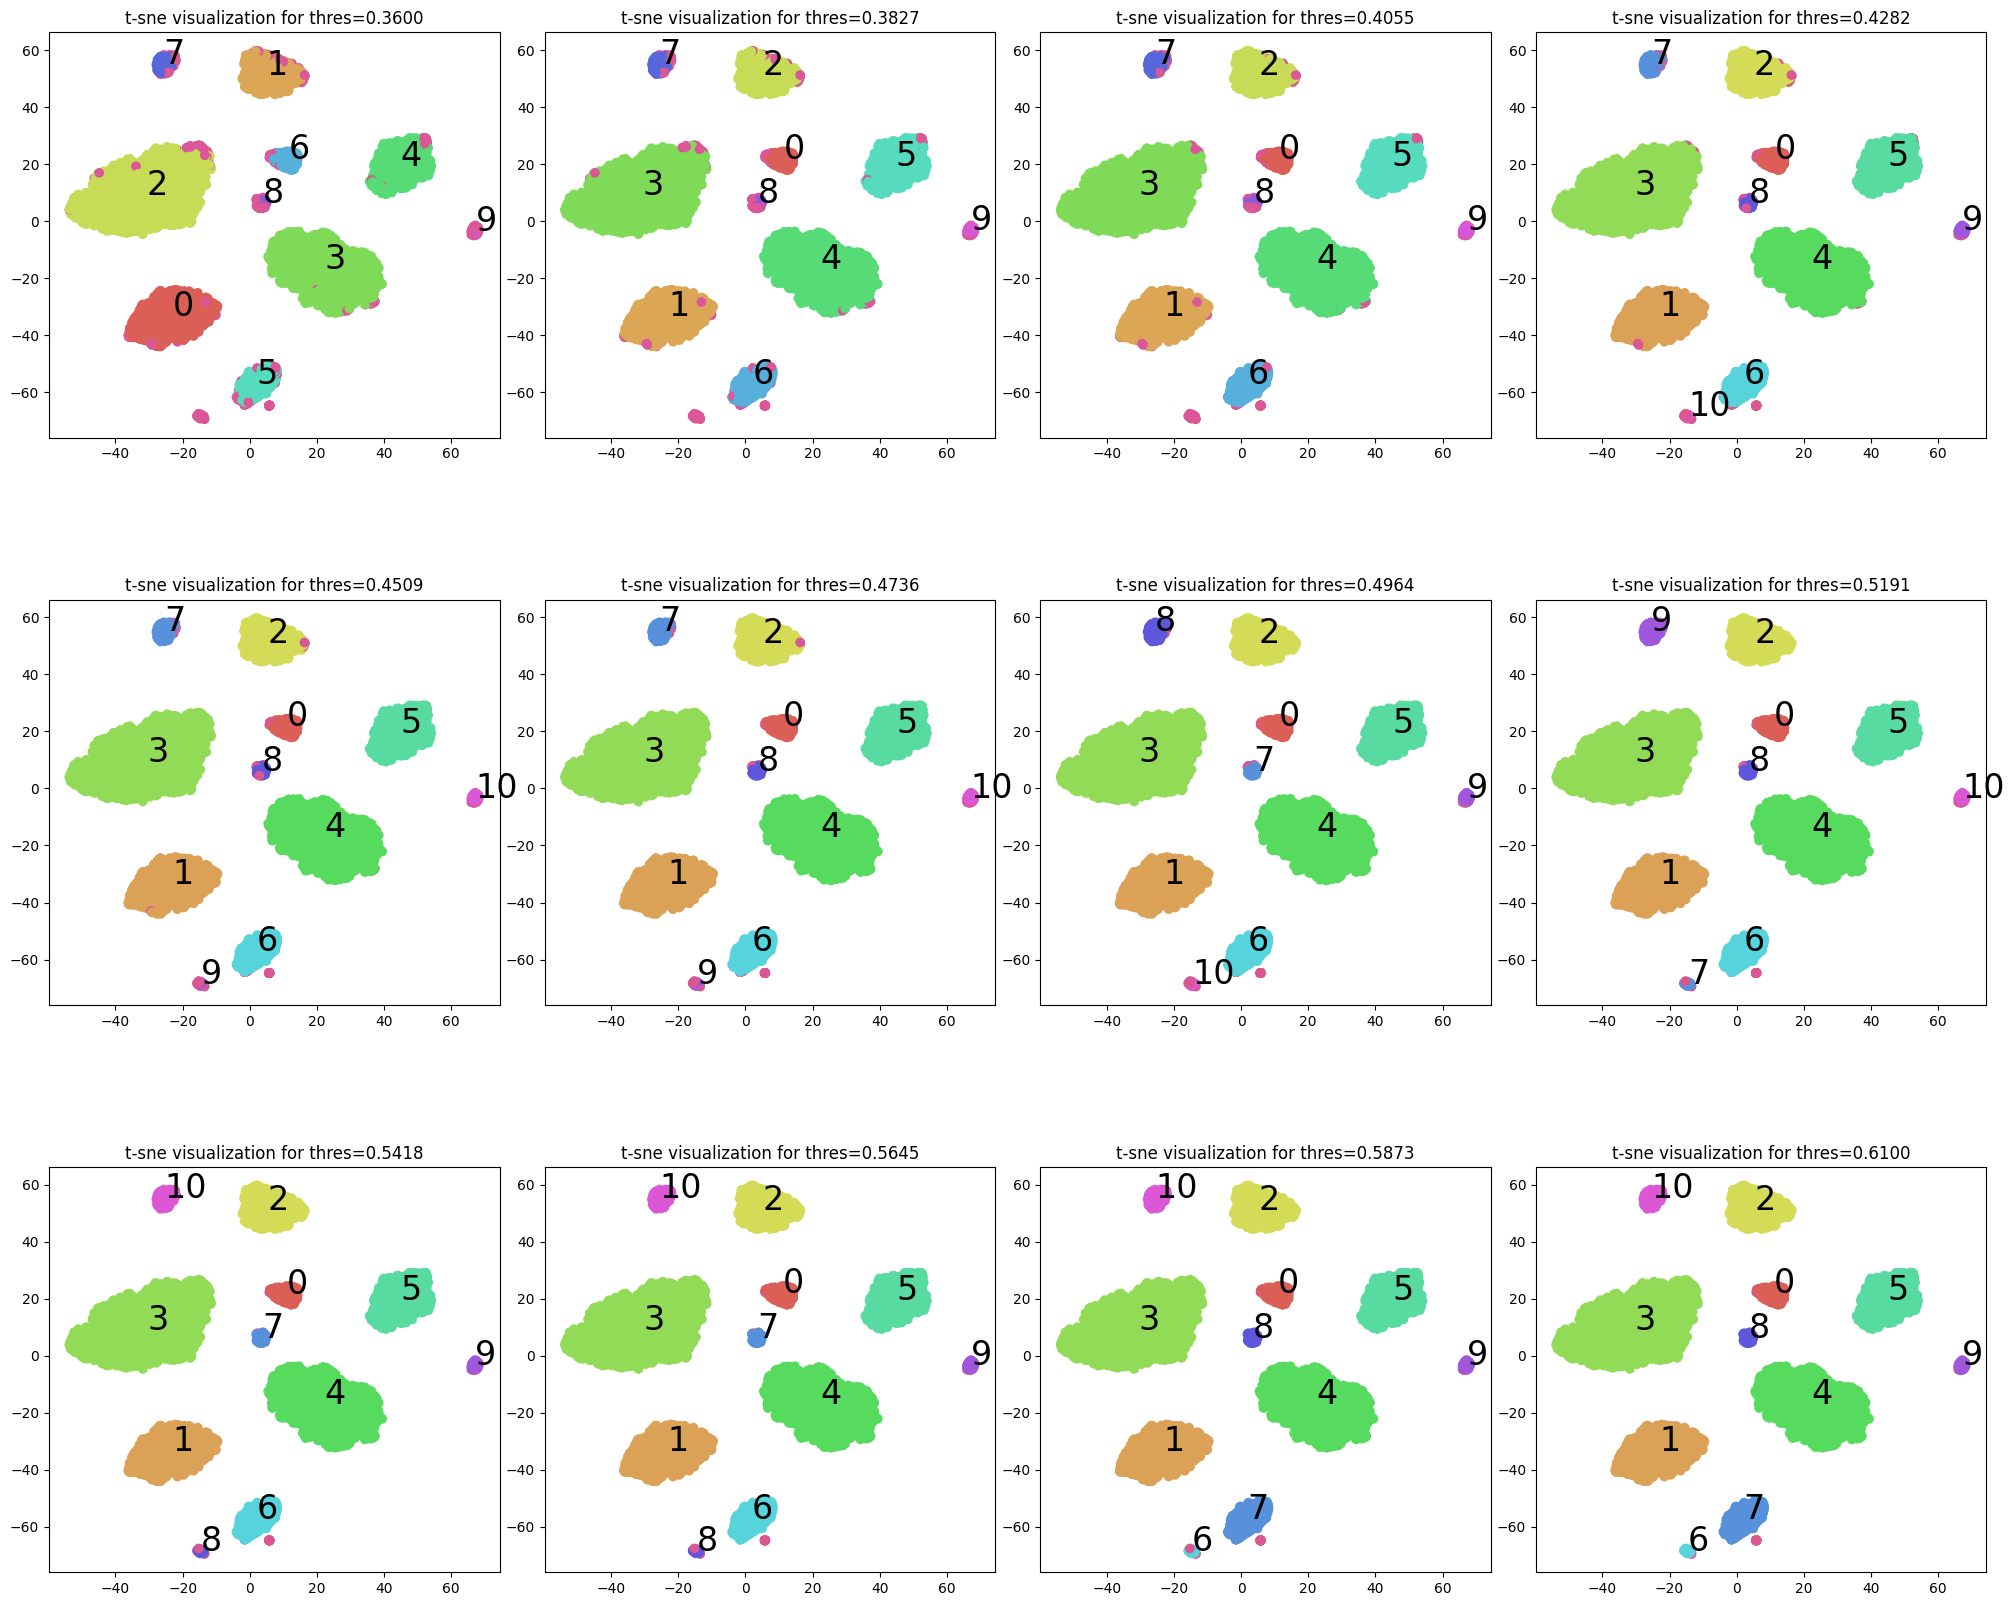

In [323]:
gs = GridSpec(3, 4) 
plt.figure(figsize = (25, 20))
plt.subplots_adjust(wspace=0.1,hspace=0.4)

for i, thres in enumerate(np.linspace(0.36, 0.61, 12)):
    dbscan = DBSCAN(eps=thres, min_samples=2*22+1, metric='euclidean')
    labels = dbscan.fit_predict(players) 
    print(len(np.unique(labels)),end=' ')
    _plot_kmean_scatter(players_tsne, labels, gs[i], thres) 

```Nhận xét```
- Giá trị eps = 0.5418 cho kết quả cụm rõ ràng và ít giá trị ngoại lệ không được phân cụm

In [324]:
thres = 0.5418
dbscan = DBSCAN(eps=0.5418, min_samples=2*22+1)
labels = dbscan.fit_predict(players) 

Text(0.5, 1.0, 't-sne visualization for thres=0.5418')

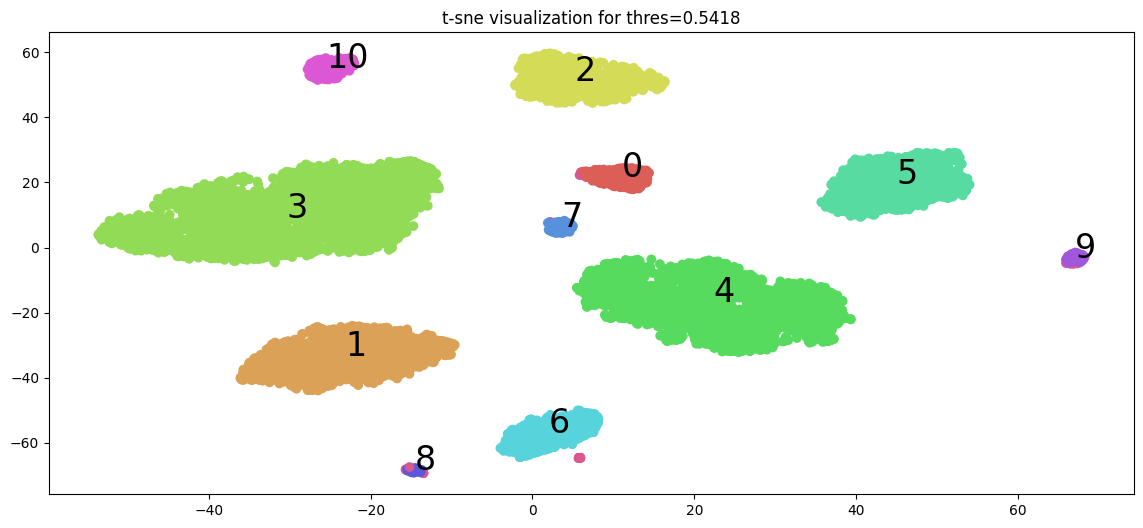

In [325]:
# px.scatter(x=players_tsne[:,0], y=players_tsne[:,1], color=labels)
num_classes = len(np.unique(labels))
palette = np.array(sns.color_palette("hls", num_classes))

ax = plt.subplot()
ax.scatter(players_tsne[:,0], players_tsne[:,1], c=palette[labels.astype(np.int64)])
txts = []
for i in range(num_classes):
    # Vẽ text tên cụm tại trung vị của mỗi cụm
    indices = (labels == i)
    xtext, ytext = np.median(players_tsne[indices, :], axis=0)
    if not (np.isnan(xtext) or np.isnan(ytext)):        
        txt = ax.text(xtext, ytext, str(i), fontsize=24) 
        txts.append(txt)
plt.title('t-sne visualization for thres={:.4f}'.format(thres))

In [326]:
players_with_labels = players_origin.copy()
players_with_labels['cluster'] = labels

In [327]:
players_with_labels['cluster'].value_counts()

cluster
 3     3358
 4     2607
 1     1617
 5     1285
 2     1059
 6      672
 0      357
 10     288
 7      150
 9      127
 8       84
-1       47
Name: count, dtype: int64

In [328]:
# Chuyển ngược từ giá trị mã hóa về giá trị ban đầu
players_original_with_labels = players_with_labels.copy() 
tmp = [] 
for i in range(len(players_original_with_labels)): 
    if players_original_with_labels.iloc[i,15] == True: 
        tmp.append('D')  
    elif players_original_with_labels.iloc[i,16] == True: 
        tmp.append('F')
    elif players_original_with_labels.iloc[i,17] == True: 
        tmp.append('G')
    elif players_original_with_labels.iloc[i,18] == True: 
        tmp.append('M') 
players_original_with_labels['position'] = tmp 
# players_original_with_labels.insert(15, 'position', tmp)
tmp2 = []
for i in range(len(players_original_with_labels)): 
    if players_original_with_labels.iloc[i,19] == True: 
        tmp2.append('Both')  
    elif players_original_with_labels.iloc[i,20] == True: 
        tmp2.append('Left')
    elif players_original_with_labels.iloc[i,21] == True: 
        tmp2.append('Right') 
 

players_original_with_labels['preferred_foot'] = tmp2   
players_original_with_labels = players_original_with_labels.drop(['pos_D', 'pos_F', 'pos_G', 'pos_M', 'foot_Both', 'foot_Left', 'foot_Right'], axis=1) 

In [329]:
players_original_with_labels.head(3)

market_value  age  height  attacking  technical  tactical  defending  \
0          7400   22     189         68         55        51         33   
1          2500   25     179         62         48        54         32   
2          1200   22     184         64         51        45         29   

   creativity  saves  anticipation  ball_distribution  aerial  \
0          49      0             0                  0       0   
1          47      0             0                  0       0   
2          48      0             0                  0       0   

   avg_score_last_12_months  appearances_last_12_months  point_of_tournament  \
0                      7.14                          33               1858.0   
1                      6.86                          37               1858.0   
2                      6.80                          34               1858.0   

   cluster position preferred_foot  
0        0        F           Left  
1        1        F          Right  
2        1        F          Right

In [330]:
player_cluster_0 = players_original_with_labels[players_original_with_labels['cluster'] == 0]
player_cluster_1 = players_original_with_labels[players_original_with_labels['cluster'] == 1]
player_cluster_2 = players_original_with_labels[players_original_with_labels['cluster'] == 2]
player_cluster_3 = players_original_with_labels[players_original_with_labels['cluster'] == 3]
player_cluster_4 = players_original_with_labels[players_original_with_labels['cluster'] == 4]
player_cluster_5 = players_original_with_labels[players_original_with_labels['cluster'] == 5]
player_cluster_6 = players_original_with_labels[players_original_with_labels['cluster'] == 6]
player_cluster_7 = players_original_with_labels[players_original_with_labels['cluster'] == 7]
player_cluster_8 = players_original_with_labels[players_original_with_labels['cluster'] == 8]
player_cluster_9 = players_original_with_labels[players_original_with_labels['cluster'] == 9]
player_cluster_10 = players_original_with_labels[players_original_with_labels['cluster'] == 10]

In [331]:
# Dữ liệu cho các cluster
clusters = [player_cluster_0, player_cluster_1, player_cluster_2, player_cluster_3, player_cluster_4, 
            player_cluster_5, player_cluster_6, player_cluster_7, player_cluster_8, player_cluster_9, player_cluster_10]
# Dữ liệu cho các cluster độ cao
clusters_height = [player_cluster_0['height'], player_cluster_1['height'], player_cluster_2['height'], 
                   player_cluster_3['height'], player_cluster_4['height'], player_cluster_5['height'], 
                   player_cluster_6['height'], player_cluster_7['height'], player_cluster_8['height'], 
                   player_cluster_9['height'], player_cluster_10['height']]
# Dữ liệu cho các cluster độ tuổi
clusters_age = [player_cluster_0['age'], player_cluster_1['age'], player_cluster_2['age'], 
                    player_cluster_3['age'], player_cluster_4['age'], player_cluster_5['age'], 
                    player_cluster_6['age'], player_cluster_7['age'], player_cluster_8['age'],
                    player_cluster_9['age'], player_cluster_10['age']]
# Dữ liệu cho các cluster điểm số trung bình
clusters_scores = [player_cluster_0['avg_score_last_12_months'], player_cluster_1['avg_score_last_12_months'], player_cluster_2['avg_score_last_12_months'], 
                    player_cluster_3['avg_score_last_12_months'], player_cluster_4['avg_score_last_12_months'], player_cluster_5['avg_score_last_12_months'], 
                    player_cluster_6['avg_score_last_12_months'], player_cluster_7['avg_score_last_12_months'], player_cluster_8['avg_score_last_12_months'],
                    player_cluster_9['avg_score_last_12_months'], player_cluster_10['avg_score_last_12_months']]
# Dữ liệu cho các cluster điểm số trung bình
clusters_marketvalue = [player_cluster_0['market_value'], player_cluster_1['market_value'], player_cluster_2['market_value'], 
                        player_cluster_3['market_value'], player_cluster_4['market_value'], player_cluster_5['market_value'], 
                        player_cluster_6['market_value'], player_cluster_7['market_value'], player_cluster_8['market_value'],
                        player_cluster_9['market_value'], player_cluster_10['market_value']]
# Dữ liệu cho các cluster số lần xuất hiện
clusters_appearances_last_12_months = [player_cluster_0['appearances_last_12_months'], player_cluster_1['appearances_last_12_months'], player_cluster_2['appearances_last_12_months'], 
                   player_cluster_3['appearances_last_12_months'], player_cluster_4['appearances_last_12_months'], player_cluster_5['appearances_last_12_months'], 
                   player_cluster_6['appearances_last_12_months'], player_cluster_7['appearances_last_12_months'], player_cluster_8['appearances_last_12_months'],
                    player_cluster_9['appearances_last_12_months'], player_cluster_10['appearances_last_12_months']]
# Dữ liệu cho các cluster: giá trị thị trường 
clusters_market_value = [player_cluster_0['market_value'], player_cluster_1['market_value'], player_cluster_2['market_value'], 
                   player_cluster_3['market_value'], player_cluster_4['market_value'], player_cluster_5['market_value'], 
                   player_cluster_6['market_value'], player_cluster_7['market_value'], player_cluster_8['market_value'],
                    player_cluster_9['market_value'], player_cluster_10['market_value']]
# Dữ liệu cho các cluster : các chỉ số
clusters_attacking = [player_cluster_0['attacking'], player_cluster_1['attacking'], player_cluster_2['attacking'], 
                   player_cluster_3['attacking'], player_cluster_4['attacking'], player_cluster_5['attacking'], 
                   player_cluster_6['attacking'], player_cluster_7['attacking'], player_cluster_8['attacking'],
                    player_cluster_9['attacking'], player_cluster_10['attacking']]
clusters_technical = [player_cluster_0['technical'], player_cluster_1['technical'], player_cluster_2['technical'], 
                   player_cluster_3['technical'], player_cluster_4['technical'], player_cluster_5['technical'], 
                   player_cluster_6['technical'], player_cluster_7['technical'], player_cluster_8['technical'],
                    player_cluster_9['technical'], player_cluster_10['technical']]
clusters_tactical = [player_cluster_0['tactical'], player_cluster_1['tactical'], player_cluster_2['tactical'], 
                   player_cluster_3['tactical'], player_cluster_4['tactical'], player_cluster_5['tactical'], 
                   player_cluster_6['tactical'], player_cluster_7['tactical'], player_cluster_8['tactical'],
                    player_cluster_9['tactical'], player_cluster_10['tactical']]
clusters_defending = [player_cluster_0['defending'], player_cluster_1['defending'], player_cluster_2['defending'], 
                   player_cluster_3['defending'], player_cluster_4['defending'], player_cluster_5['defending'], 
                   player_cluster_6['defending'], player_cluster_7['defending'], player_cluster_8['defending'],
                    player_cluster_9['defending'], player_cluster_10['defending']]
clusters_creativity = [player_cluster_0['creativity'], player_cluster_1['creativity'], player_cluster_2['creativity'], 
                   player_cluster_3['creativity'], player_cluster_4['creativity'], player_cluster_5['creativity'], 
                   player_cluster_6['creativity'], player_cluster_7['creativity'], player_cluster_8['creativity'],
                    player_cluster_9['creativity'], player_cluster_10['creativity']]
clusters_saves = [player_cluster_0['saves'], player_cluster_1['saves'], player_cluster_2['saves'], 
                   player_cluster_3['saves'], player_cluster_4['saves'], player_cluster_5['saves'], 
                   player_cluster_6['saves'], player_cluster_7['saves'], player_cluster_8['saves'],
                    player_cluster_9['saves'], player_cluster_10['saves']]
clusters_anticipation = [player_cluster_0['anticipation'], player_cluster_1['anticipation'], player_cluster_2['anticipation'], 
                   player_cluster_3['anticipation'], player_cluster_4['anticipation'], player_cluster_5['anticipation'], 
                   player_cluster_6['anticipation'], player_cluster_7['anticipation'], player_cluster_8['anticipation'],
                    player_cluster_9['anticipation'], player_cluster_10['anticipation']]
clusters_ball_distribution = [player_cluster_0['ball_distribution'], player_cluster_1['ball_distribution'], player_cluster_2['ball_distribution'], 
                   player_cluster_3['ball_distribution'], player_cluster_4['ball_distribution'], player_cluster_5['ball_distribution'], 
                   player_cluster_6['ball_distribution'], player_cluster_7['ball_distribution'], player_cluster_8['ball_distribution'],
                    player_cluster_9['ball_distribution'], player_cluster_10['ball_distribution']]
clusters_aerial = [player_cluster_0['aerial'], player_cluster_1['aerial'], player_cluster_2['aerial'], 
                   player_cluster_3['aerial'], player_cluster_4['aerial'], player_cluster_5['aerial'], 
                   player_cluster_6['aerial'], player_cluster_7['aerial'], player_cluster_8['aerial'],
                    player_cluster_9['aerial'], player_cluster_10['aerial']]
clusters_point_of_tournament = [player_cluster_0['point_of_tournament'], player_cluster_1['point_of_tournament'], player_cluster_2['point_of_tournament'], 
                   player_cluster_3['point_of_tournament'], player_cluster_4['point_of_tournament'], player_cluster_5['point_of_tournament'], 
                   player_cluster_6['point_of_tournament'], player_cluster_7['point_of_tournament'], player_cluster_8['point_of_tournament'],
                    player_cluster_9['point_of_tournament'], player_cluster_10['point_of_tournament']]
# -----------------------------------------------------------------
# -----------------------------------------------------------------
# -----------------------------------------------------------------
# Màu sắc cho các boxplot của từng cluster độ cao
box_colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightpink', 'lightyellow', 'lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightpink']

``Khảo sát các vị trí đá của cầu thủ trong các cụm``

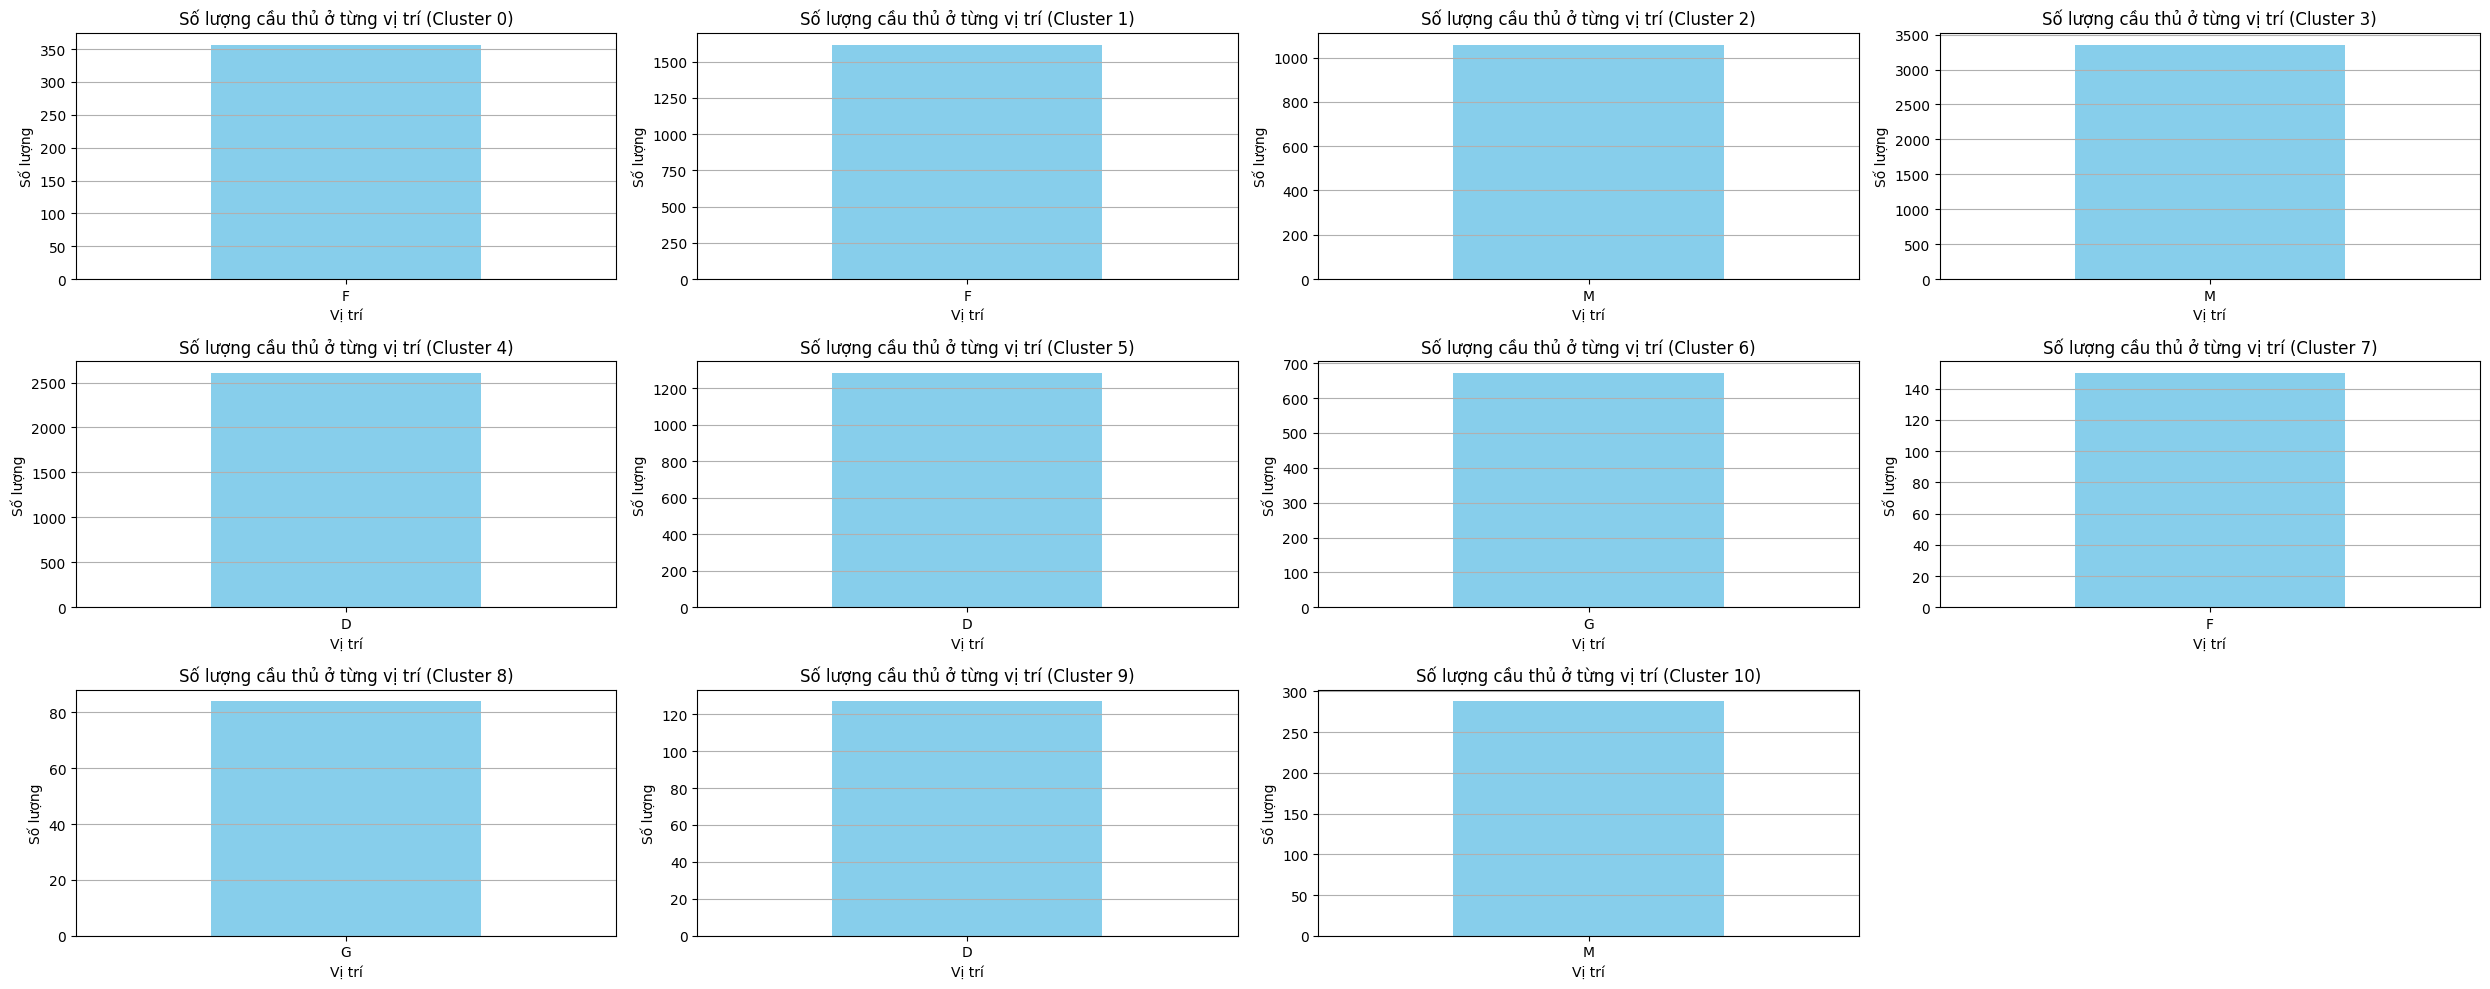

In [332]:
plt.figure(figsize=(25, 10)) 
for i, cluster_data in enumerate(clusters): 
    positions = cluster_data['position']
    position_counts = positions.value_counts()
    plt.subplot(3, 4, i+1)
    position_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
    plt.xlabel('Vị trí')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=0)
    plt.grid(axis='y') 
plt.tight_layout()
plt.show()

**Nhận xét:**
- Cụm 0, 1 và 7: có duy nhất vị trí cầu thủ là Tiền đạo(F)
- Cụm 2, 3 và 10: có duy nhất vị trí cầu thủ là Tiền về(M)
- Cụm 4, 5 và 9: có cả 2 vị trí cầu thù là Hậu vệ(D)
- Cụm 6 và 8: có duy nhất vị trí cầu thủ là Thủ môn(G)

``Khảo sát theo (độ tuổi, chiều cao, điểm số trung bình trong 12 tháng gần nhất, số lần xuất hiện trong 12 tháng gần nhất )``

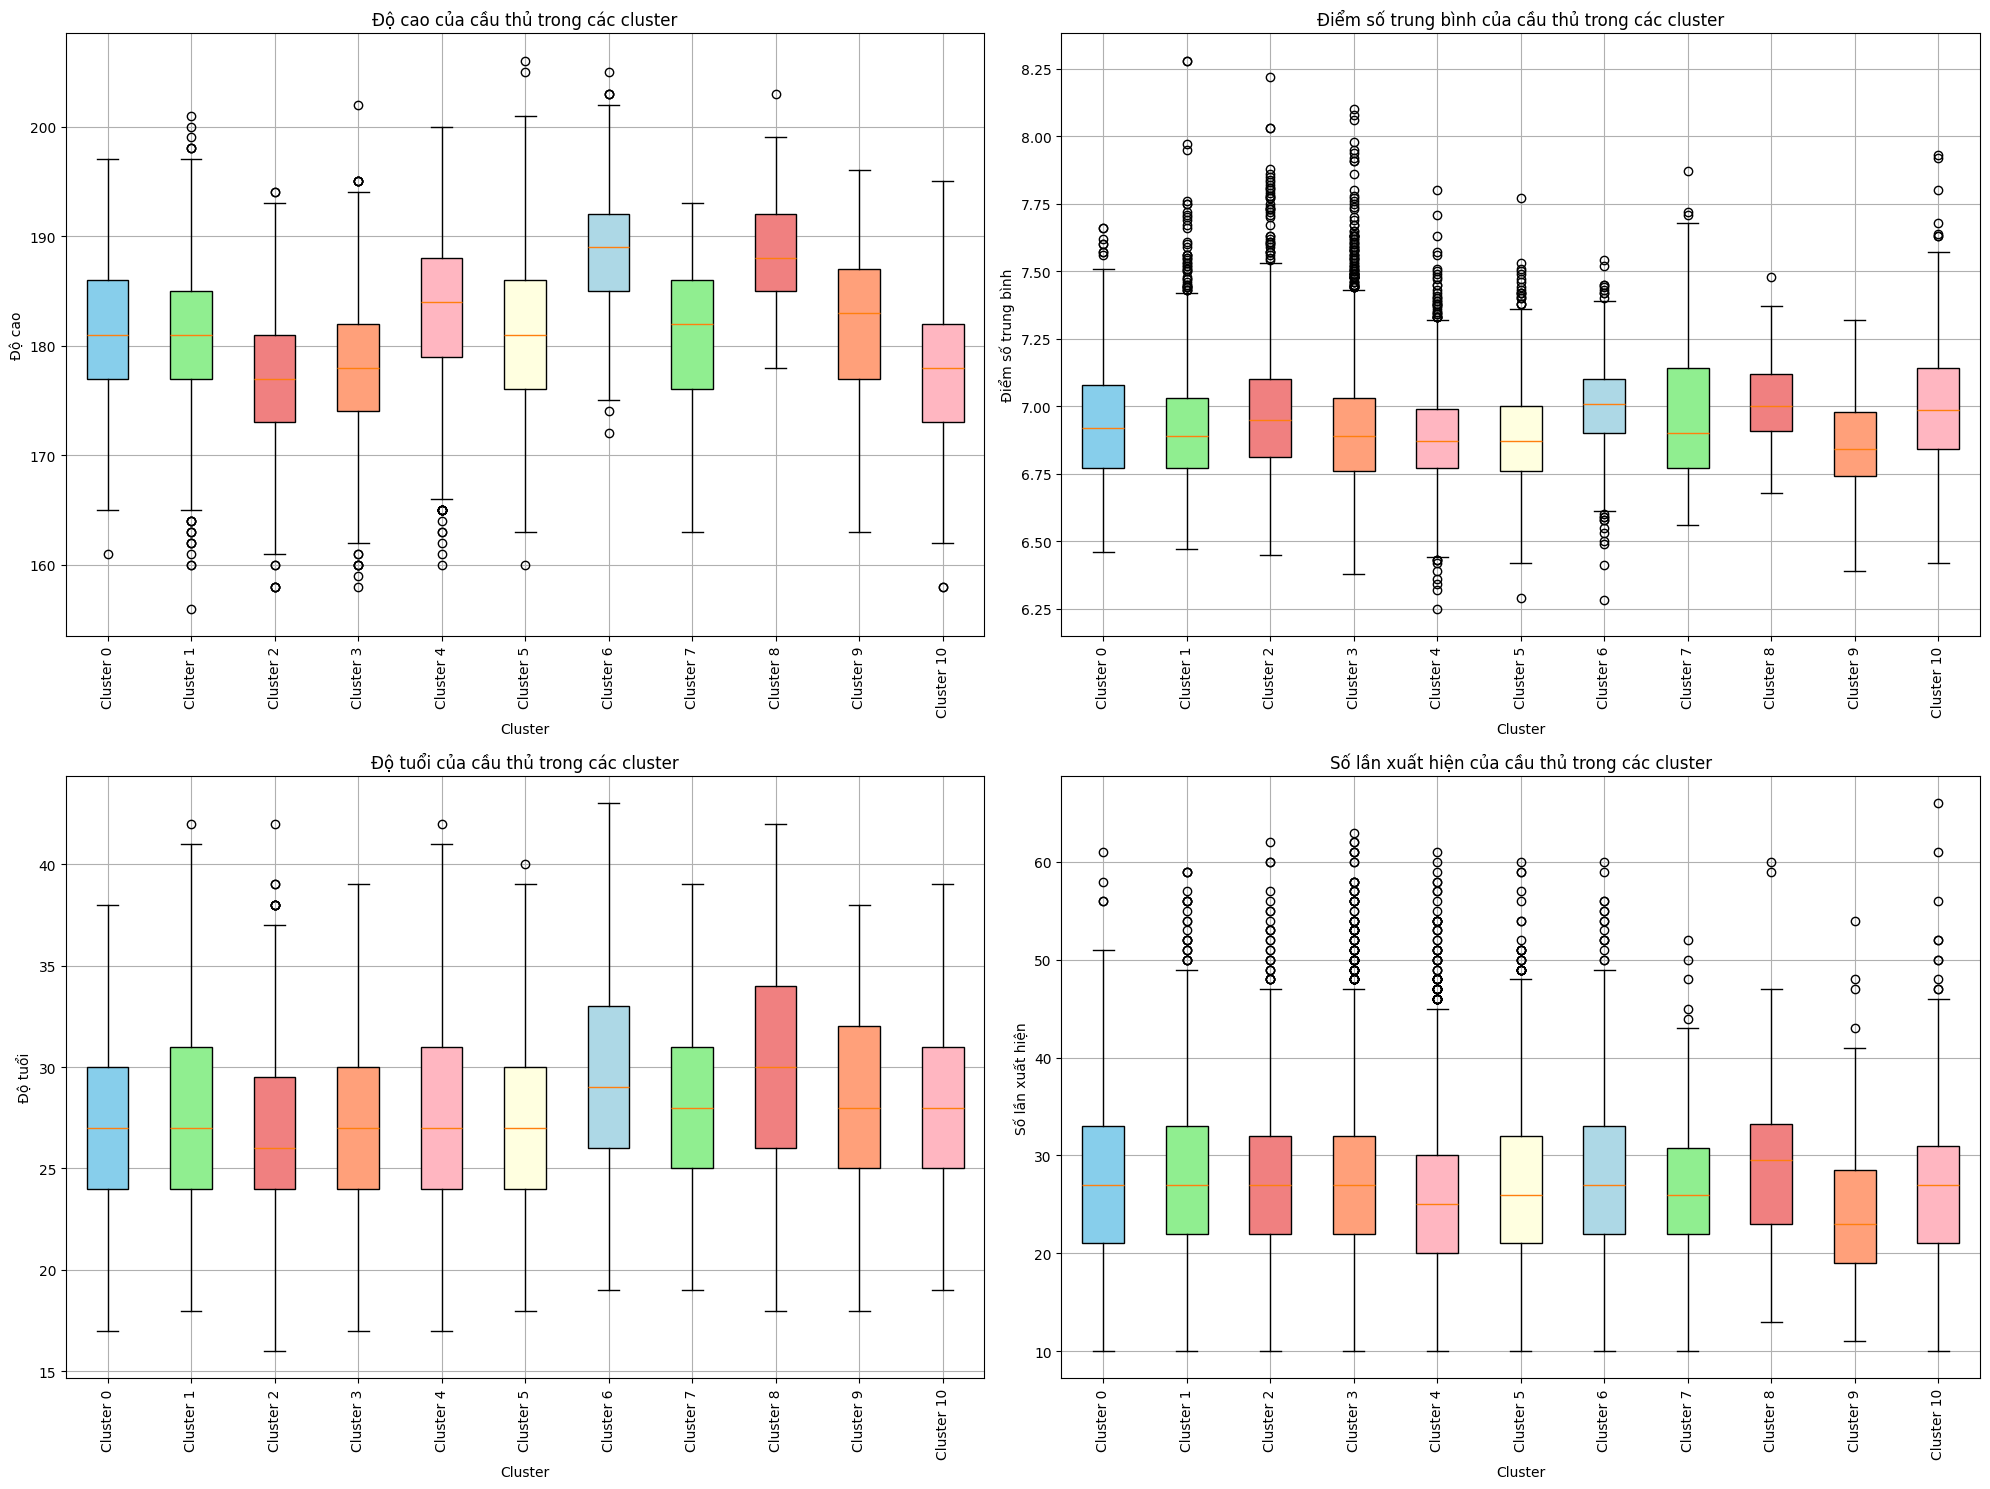

In [333]:
plt.figure(figsize=(20, 15))
# -----------------------------------------------------------------
# Biểu đồ boxplot cho độ cao
plt.subplot(2, 2, 1)
boxplot_height = plt.boxplot(clusters_height, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                      'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 
                                                      'Cluster 8', 'Cluster 9', 'Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Độ cao của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Độ cao')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho điểm số trung bình
plt.subplot(2, 2, 2)
boxplot_scores = plt.boxplot(clusters_scores, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 
        'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7','Cluster 8', 'Cluster 9', 'Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_scores['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Điểm số trung bình của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Điểm số trung bình')
plt.xticks(rotation=90)
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho độ tuôi
plt.subplot(2, 2, 3)
boxplot_height = plt.boxplot(clusters_age, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 
                                                   'Cluster 6', 'Cluster 7','Cluster 8', 'Cluster 9', 'Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Độ tuổi của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Độ tuổi')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho số lần xuất hiện
plt.subplot(2, 2, 4)
boxplot_height = plt.boxplot(clusters_appearances_last_12_months, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                                          'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                                          'Cluster 8', 'Cluster 9', 'Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Số lần xuất hiện của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Số lần xuất hiện')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()


**Nhận xét:**
- Các cụm về Tiền đạo(F): Tiền đạo trong cụm 0, 1 và 7 có các thông số khá tương đồng nhau
- Các cụm về Tiền vệ(M): Tiền vệ trong các cụm 2, 3 và 10 có các chỉ số khá tương đồng nhau
- Các cụm về Hậu vệ(D): Hậu vệ trong các cụm 4, 5 và 9 có các chỉ số khá tương đồng nhau
- Cụm về Thủ môn(G): Cụm 6,8 là cụm chỉ riêng Thủ môn mang rõ đặc trưng của vai trò thủ môn khi có Chiều cao và độ tuổi trung bình lớn

``Khảo sát theo các chỉ số (9 chỉ số)``

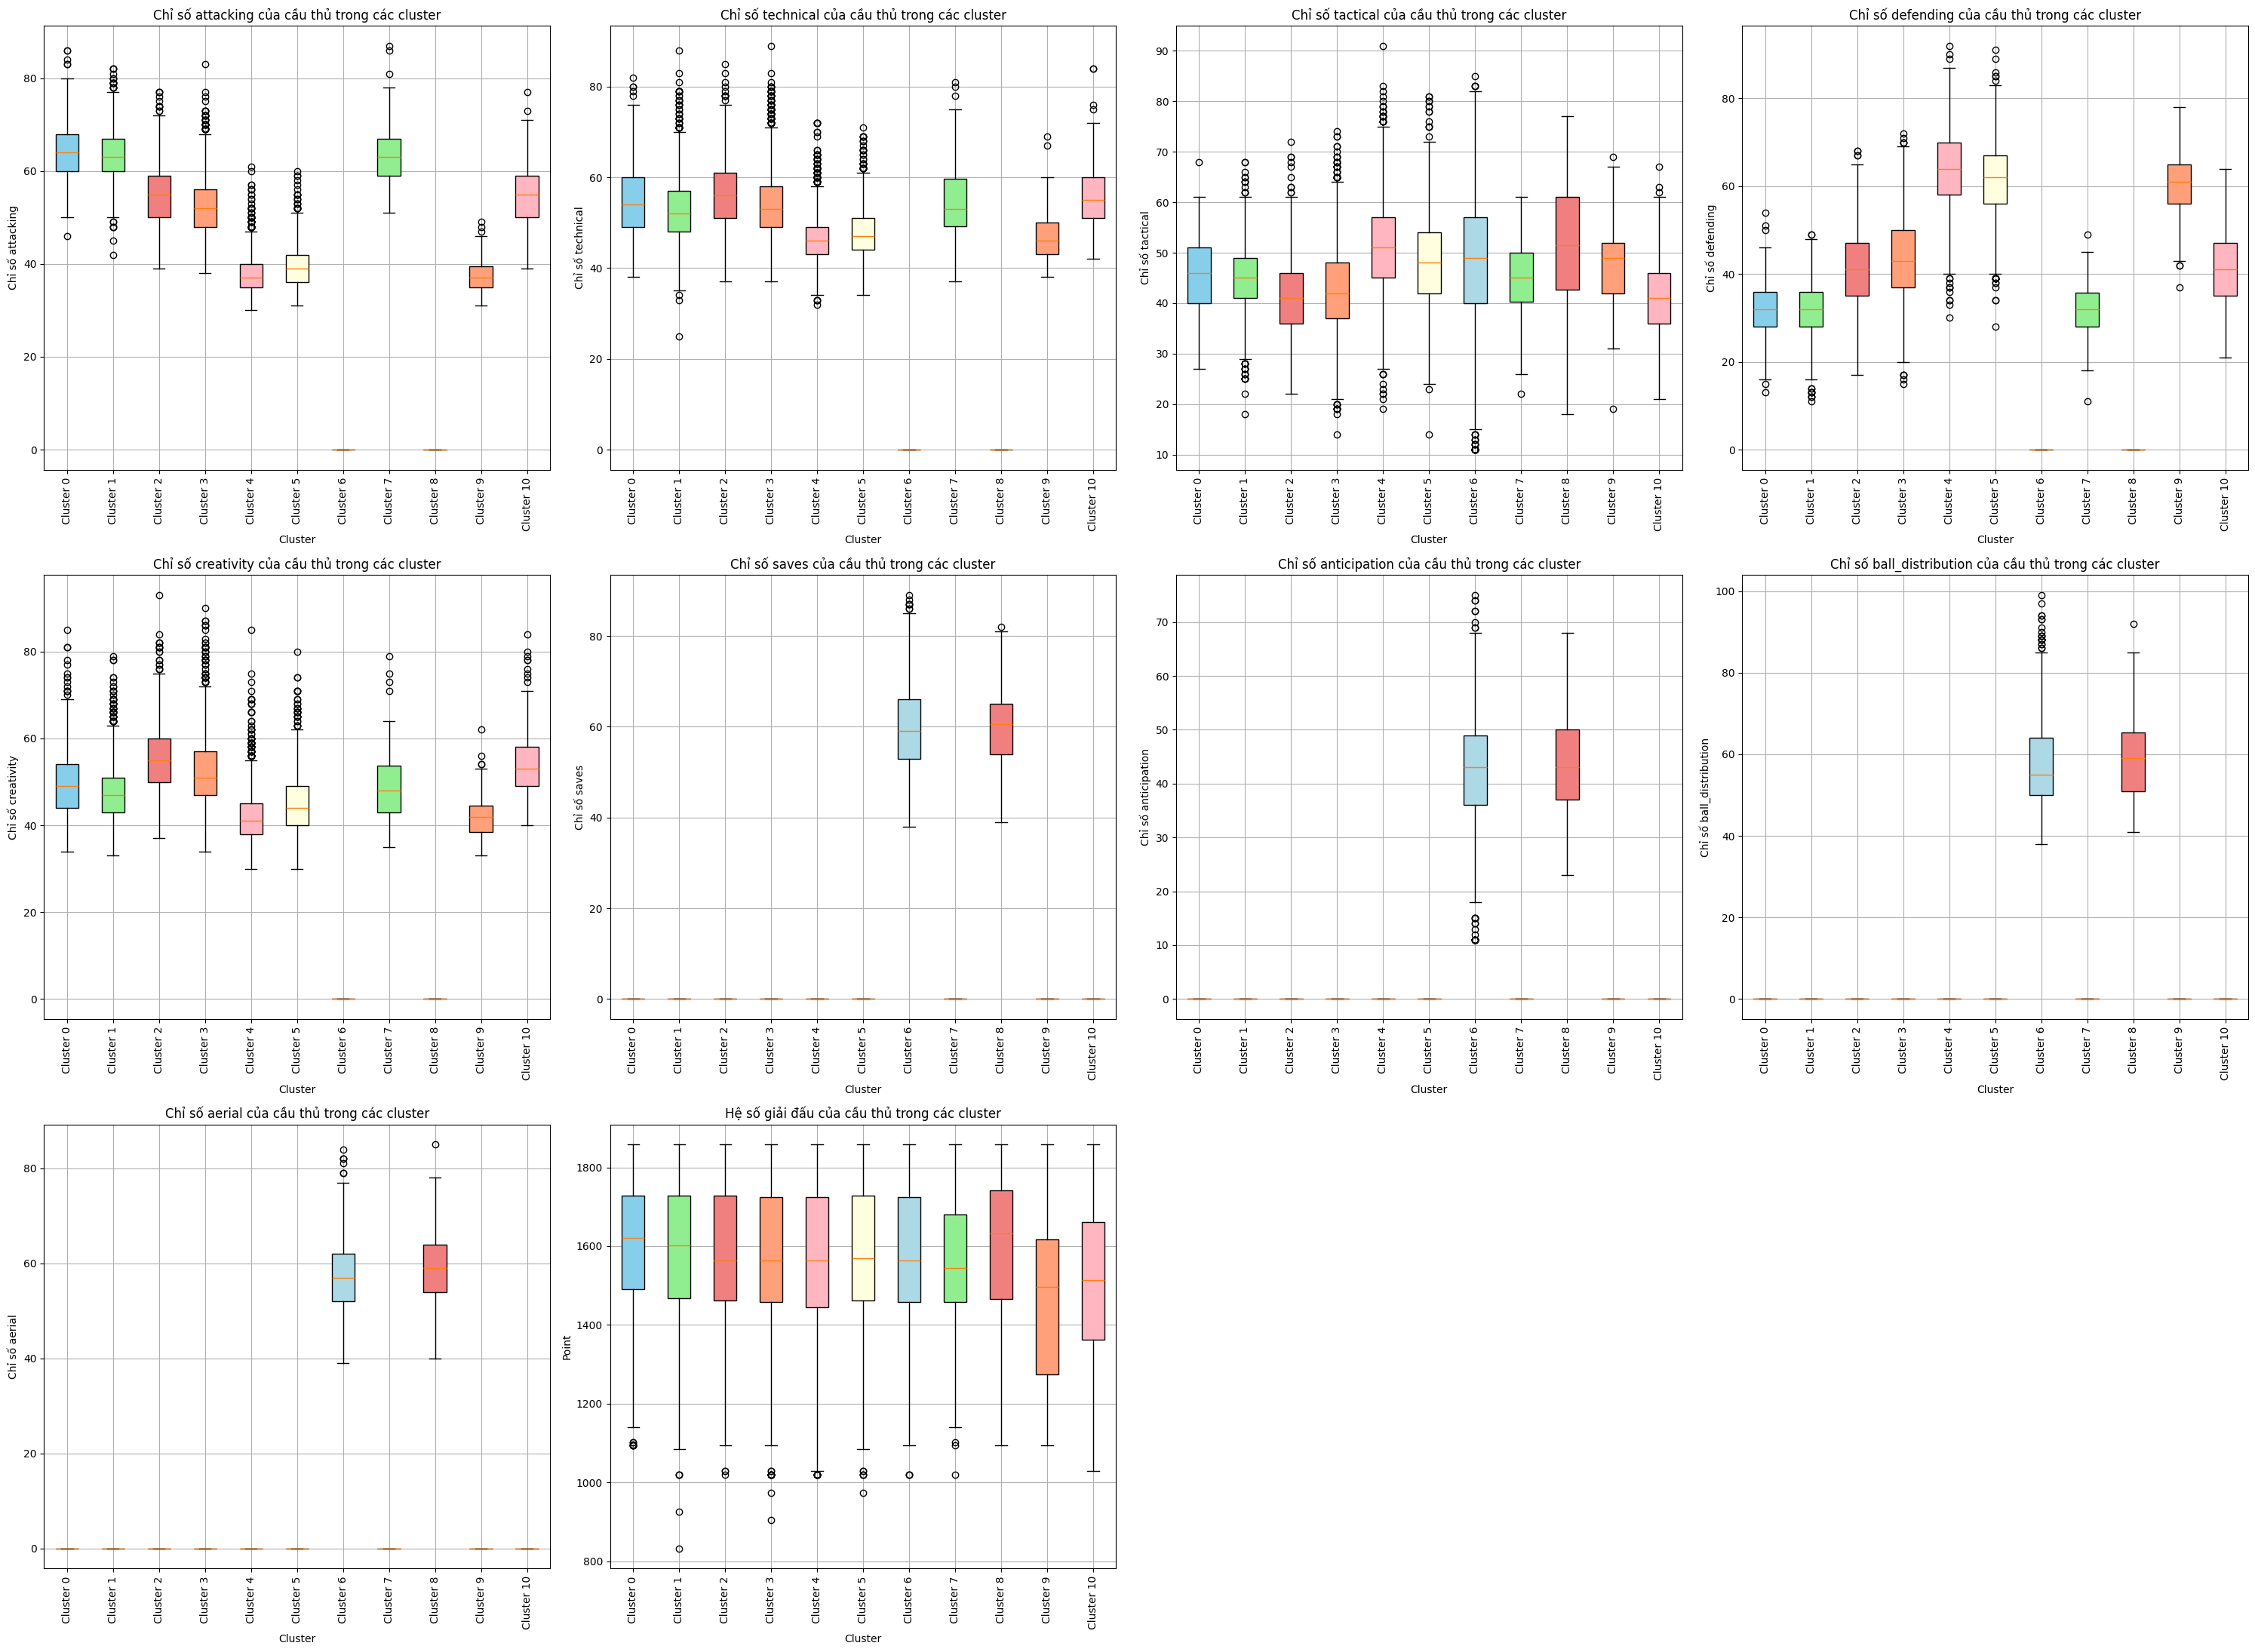

In [334]:
plt.figure(figsize=(30, 22))

# Biểu đồ boxplot cho attacking
plt.subplot(3, 4, 1)
boxplot_height = plt.boxplot(clusters_attacking, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                        'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                        'Cluster 8','Cluster 9','Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số attacking của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số attacking')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho technical
plt.subplot(3, 4, 2)
boxplot_height = plt.boxplot(clusters_technical, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                        'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                        'Cluster 8','Cluster 9','Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số technical của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số technical')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho tactical
plt.subplot(3, 4, 3)
boxplot_height = plt.boxplot(clusters_tactical, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                        'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                        'Cluster 8','Cluster 9','Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số tactical của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số tactical')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho defending
plt.subplot(3, 4, 4)
boxplot_height = plt.boxplot(clusters_defending, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                        'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                        'Cluster 8','Cluster 9','Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số defending của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số defending')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho creativity
plt.subplot(3, 4, 5)
boxplot_height = plt.boxplot(clusters_creativity, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                        'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                        'Cluster 8','Cluster 9','Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số creativity của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số creativity')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho saves
plt.subplot(3, 4, 6)
boxplot_height = plt.boxplot(clusters_saves, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                        'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                        'Cluster 8','Cluster 9','Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số saves của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số saves')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho anticipation
plt.subplot(3, 4, 7)
boxplot_height = plt.boxplot(clusters_anticipation, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                        'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                        'Cluster 8','Cluster 9','Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số anticipation của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số anticipation')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho ball_distribution
plt.subplot(3, 4, 8)
boxplot_height = plt.boxplot(clusters_ball_distribution, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                        'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                        'Cluster 8','Cluster 9','Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số ball_distribution của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số ball_distribution')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
# Biểu đồ boxplot cho aerial
plt.subplot(3, 4, 9)
boxplot_height = plt.boxplot(clusters_aerial, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                        'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                        'Cluster 8','Cluster 9','Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Chỉ số aerial của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Chỉ số aerial')
plt.xticks(rotation=90)
plt.grid(True)
# -----------------------------------------------------------------
# Biểu đồ boxplot cho hệ số giải đấu
plt.subplot(3, 4, 10)
boxplot_height = plt.boxplot(clusters_point_of_tournament, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                        'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                        'Cluster 8','Cluster 9','Cluster 10'], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Hệ số giải đấu của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Point')
plt.xticks(rotation=90)
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()

**Nhận xét:** 
- Các cụm về Tiền đạo(F): các cầu thủ trong các cụm 0, 1 và 7 có các chỉ số khá tương đồng nhau. Cụm 0 và cụm 1 là cụm có các cầu thủ thi đấu ở giải có hệ số cao, trong khi đó cụm 7 là các cầu thủ thi đấu ở giải đấu có hệ số thấp hơn.
- Cụm về Tiền vệ(M): Cụm 2 và 10 có chỉ số Attacking, Technical, Creativity cao hơn cụm 3. Cụm 3 có chỉ số defending cao hơn cụm 2, 10. Cụm 10 là các cầu thủ thi đấu ở giải đấu thấp nhất.
- Các cụm về Hậu vệ (D): Các cầu thủ ở cụm 4 có chỉ số Tactical và Defending cao hơn cụm 5 và 9. Cầu thủ ở cụm 5 có chỉ số Attacking cao hơn cụm 4 và 9. Cầu thủ ở cụm 9 là các cầu thủ thi đấu ở giải đấu có hệ số thấp nhất. 
- Cụm về Thủ môn(G): Cụm 8 là các thủ môn có chỉ số Tactical, Ball_distribution, Saves và Aerial cao hơn so với cụm 6. Các cầu thủ ở cụm 8 thi đấu ở giải đấu cao hơn cụm 6

``Khảo sát theo vị trí, chân đá``

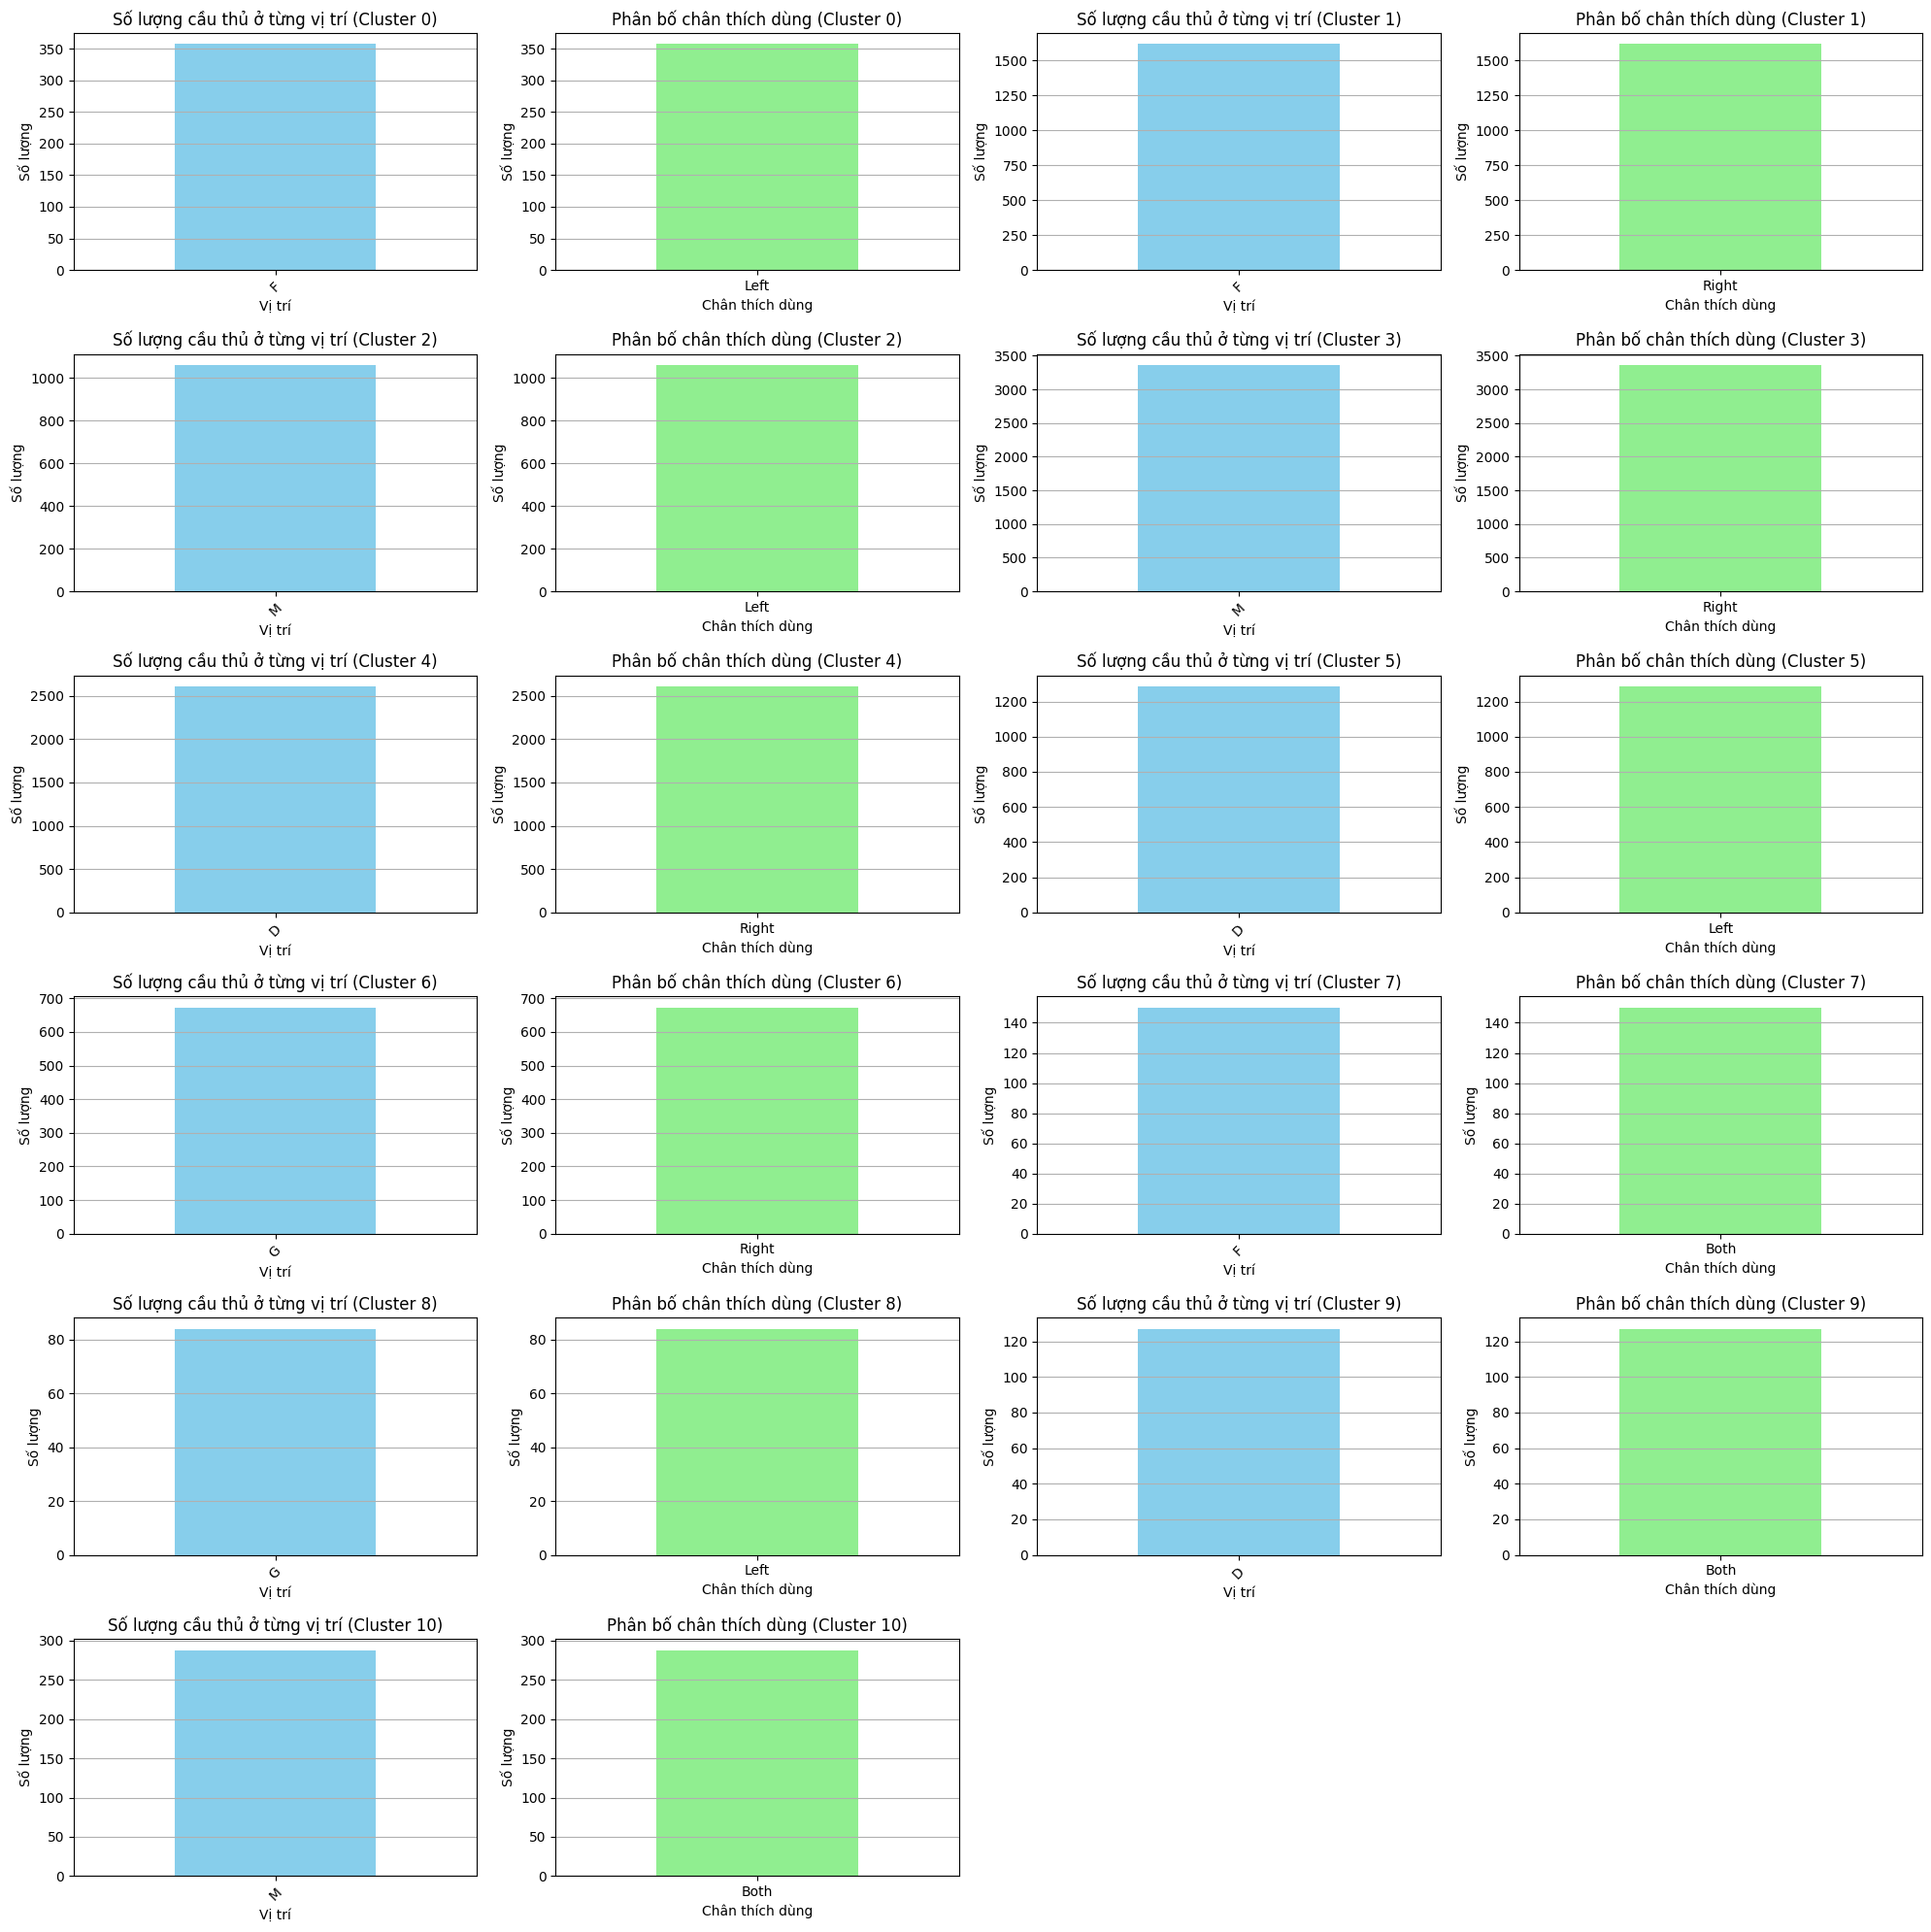

In [335]:
plt.figure(figsize=(20, 20))

for i, cluster_data in enumerate(clusters):
    positions = cluster_data['position']
    preferred_foot = cluster_data['preferred_foot']
    position_counts = positions.value_counts()
    foot_counts = preferred_foot.value_counts()

    # Biểu đồ số lượng cầu thủ ở từng vị trí
    plt.subplot(6, 4, (2 * i) + 1)
    position_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Số lượng cầu thủ ở từng vị trí (Cluster {i})')
    plt.xlabel('Vị trí')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Biểu đồ phân bố chân thích dùng
    plt.subplot(6, 4, (2 * i) + 2)
    foot_counts.plot(kind='bar', color='lightgreen')
    plt.title(f'Phân bố chân thích dùng (Cluster {i})')
    plt.xlabel('Chân thích dùng')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=0)
    plt.grid(axis='y')

plt.tight_layout()
plt.show()

**Nhận xét:**
- Các cụm về Tiền đạo(F): 
    + Cầu thủ cụm 0 sở trường đá chân Trái.
    + Cầu thủ cụm 1 sở trường đá chân Phải.
    + Cầu thủ cụm 7 sở trường cả 2 chân.
- Cụm về Tiền vệ(M):
    + Tiền vệ cụm 2 sở trường đá chân Trái.
    + Tiền vệ cụm 3 sở trường đá chân Phải.
    + Tiền vệ cụm 10 sở trường cả 2 chân.
- Cụm về Hậu vệ(M):
    + Hậu vệ cụm 4 sở trường đá chân Phải.
    + Hậu vệ cụm 5 sở trường đá chân Trái.
    + Hậu vệ cụm 10 sở trường cả 2 chân.
- Cụm về Thủ môn(G):
    + Thủ môn cụm 6 sở trường đá chân Phải.
    + Thủ môn cụm 8 sở trường đá chân Trái.

``Khảo sát theo giá trị thị trường``

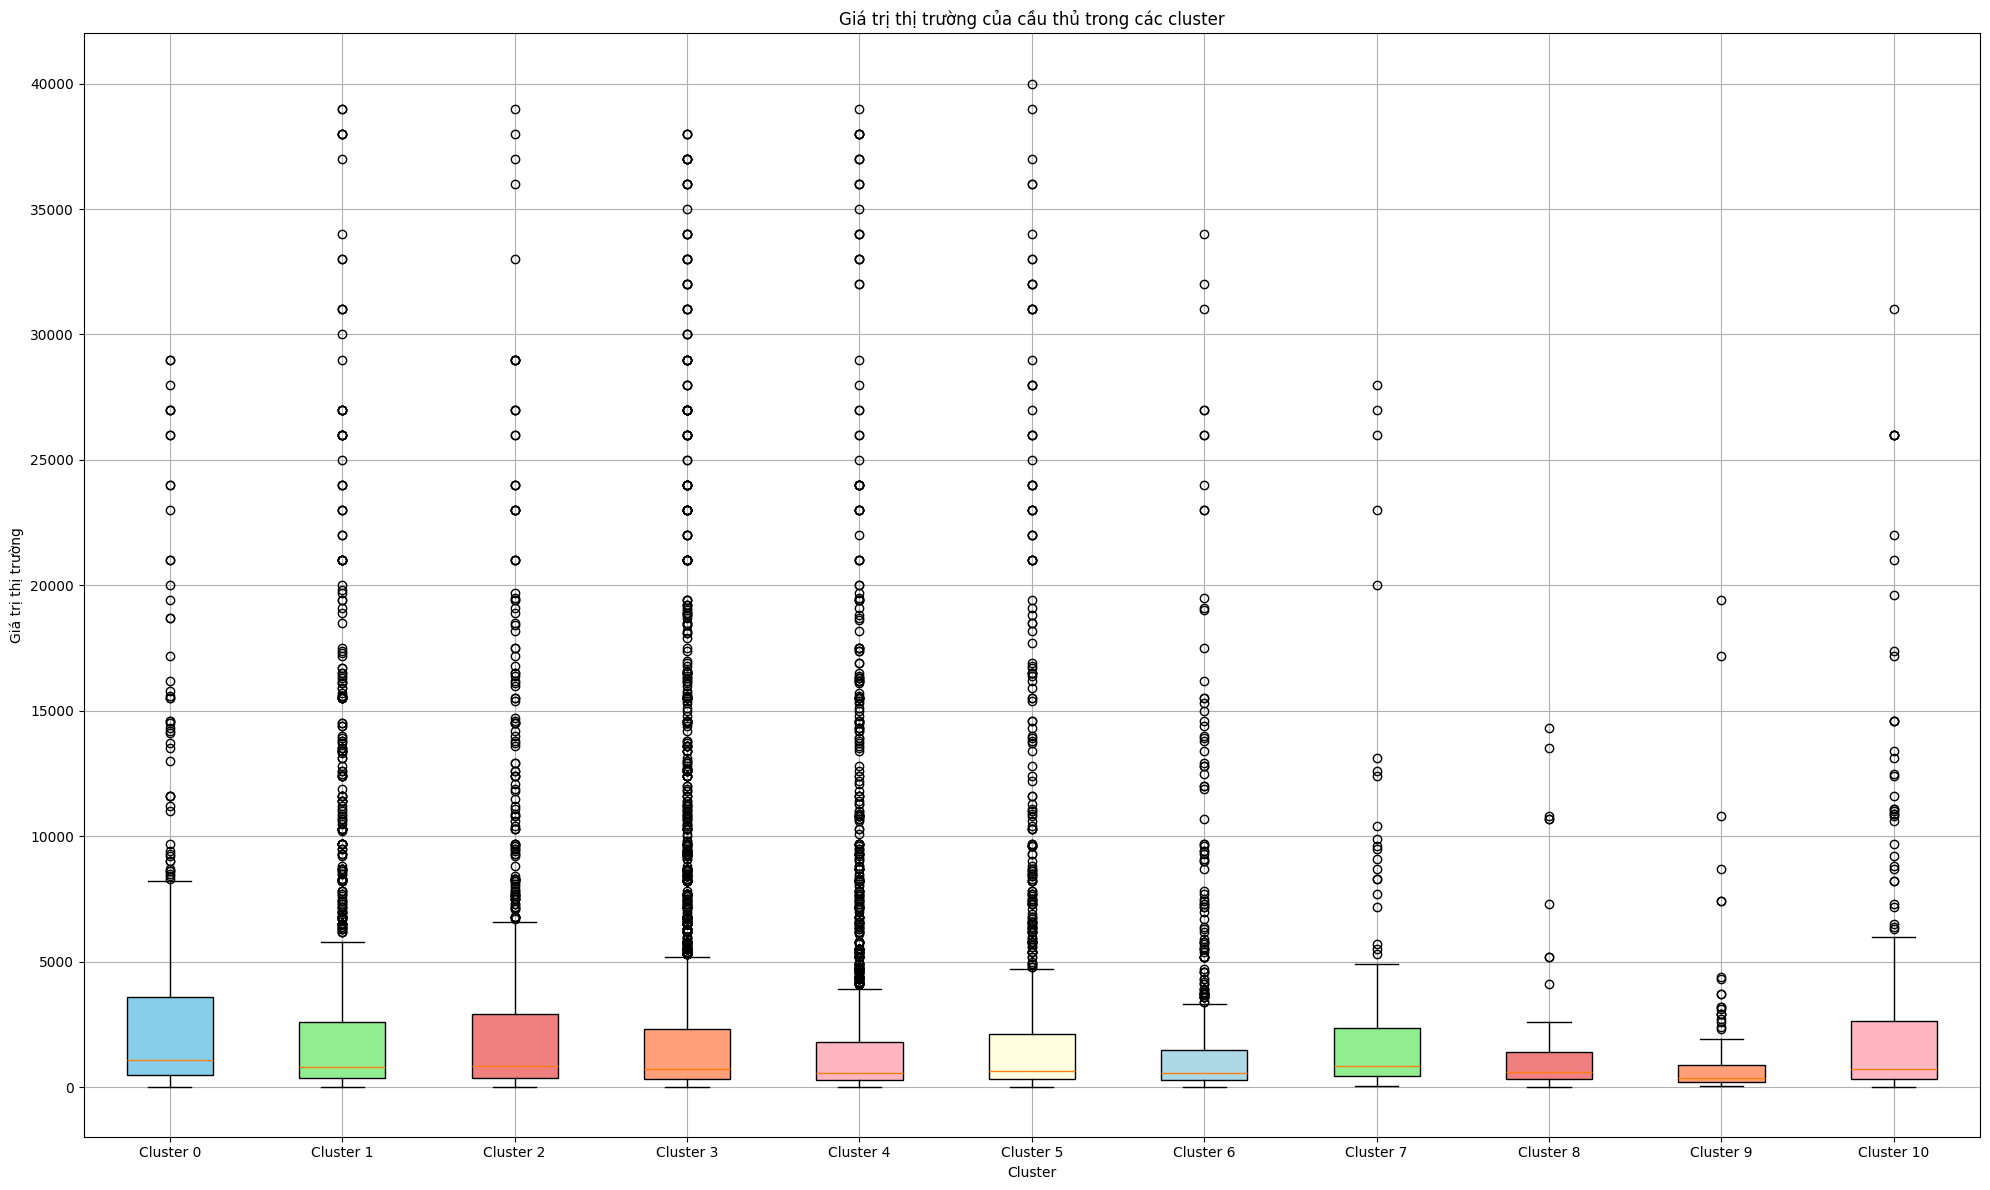

In [336]:
plt.figure(figsize=(20, 12))
 
boxplot_height = plt.boxplot(clusters_market_value, labels=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 
                                                            'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7',
                                                            'Cluster 8', 'Cluster 9', 'Cluster 10',], patch_artist=True)
for patch, color in zip(boxplot_height['boxes'], box_colors):
    patch.set_facecolor(color)
plt.title('Giá trị thị trường của cầu thủ trong các cluster')
plt.xlabel('Cluster')
plt.ylabel('Giá trị thị trường')
plt.grid(True)

# -----------------------------------------------------------------
plt.tight_layout()
plt.show()


**Nhận xét:**
- Các cụm về Tiền đạo (F): các cầu thủ trong cụm 0 có giá trị trường trung bình cao nhất trong các cụm Tiền đạo, cụm 1 và 7 có giá trị thị trường khá tương đồng nhau.
- Cụm về Tiền vệ (M): Các tiền vệ trong cụm 2, 3 và 10 có sự khác biệt về giá trị trường trung bình tuy nhiên không đáng kể.
- Cụm về Hậu vệ (D): Các cầu thủ trong cụm 5 có giá trị trường trung bình cao nhất trong các cụm hậu vệ, cụm 9 có giá trị thị trường trung bình thấp nhất.
- Cụm về Thủ môn(G): Các thủ môn trong cụm 6 và 8 có sự khác biệt về giá trị trường trung bình tuy nhiên không đáng kể.

### Đánh giá kết quả phân cụm

In [337]:
davies_dbscan = davies_bouldin_score(players_encoded, labels)
calinski_dbscan = calinski_harabasz_score(players_encoded, labels)
ssilhouette_dbscan = silhouette_score(players_encoded, labels)

print(f'Davies Bouldin Score (lower is better): {davies_dbscan}')
print(f'Calinski Harabasz Score (higher is better): {calinski_dbscan}')
print(f'Silhouette Score (higher is better): {ssilhouette_dbscan}')

Davies Bouldin Score (lower is better): 1.0232887705863725
Calinski Harabasz Score (higher is better): 8053.370614382569
Silhouette Score (higher is better): 0.6386577987714229


**``Kết luận``**
- Phương pháp phân cụm dựa trên mật độ **Density-Based Clustering** cho ra kết quả các cụm có một số tính chất khác và cũng có một số tính chất mà một số cụm có sự tương đồng về giá trị biến dữ liệu tùy theo việc xác định tham số minPts và Epsilon 
- **DBSCAN** cho ra kết quả phân cụm không thể hiển tốt mỗi quan hệ giữa các cụm.
- Các cụm thu được:
    + Cụm 0: Là Tiền đạo, thuận chân trái, giá trị trung bình cao, đang thi đấu ở giải đấu lớn.
    + Cụm 1: Là Tiền đạo, thuận chân phải, giá trị trung bình thấp.
    + Cụm 2: Là Tiền vệ, thuận chân trái, có các chỉ số attacking|technical|creativity trung bình cao.
    + Cụm 3: Là Tiền vệ, thuận chân phải, có chỉ số defending trung bình cao.
    + Cụm 4: Là Hậu vệ, thuận chân phải, có các chỉ số tactical|defending trung bình cao.
    + Cụm 5: Là Hậu vệ, thuận chân trái, có chỉ số attacking trung bình cao.
    + Cụm 6: Là Thủ môn, thuận chân phải, có các chỉ số tactical|ball_distribution|saves|aerial trung bình cao, đang thi đấu ở giải đấu lớn.
    + Cụm 7: Là Tiền đạo, thuận 2 chân, giá trị trung bình thấp, đang thi đấu ở giải đấu nhỏ.
    + Cụm 8: Là Thủ môn, thuận chân trái, có các chỉ số tactical|ball_distribution|saves|aerial trung bình thấp, đang thi đấu ở giải đấu nhỏ.
    + Cụm 9: Là Hậu vệ, thuận 2 chân, đang thi đấu ở giải đấu nhỏ.
    + Cụm 10: Là Tiền vệ, thuận 2 chân, có các chỉ số attacking|technical|creativity trung bình cao, đang thi đấu ở giải đấu nhỏ.

### 4. Kết luận, đánh giá chung

### So sánh hiệu suất phân cụm của 2 mô hình Hierarchical Clustering và DBSCAN

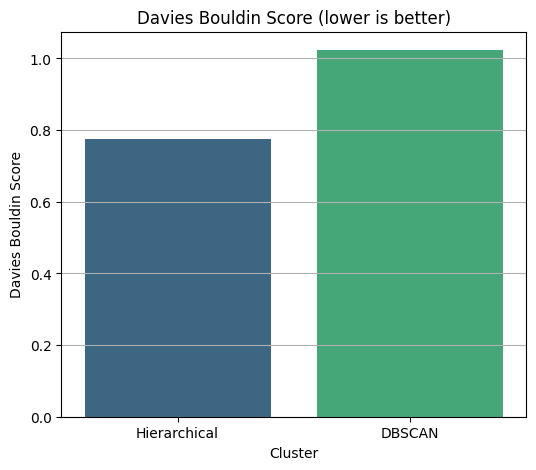

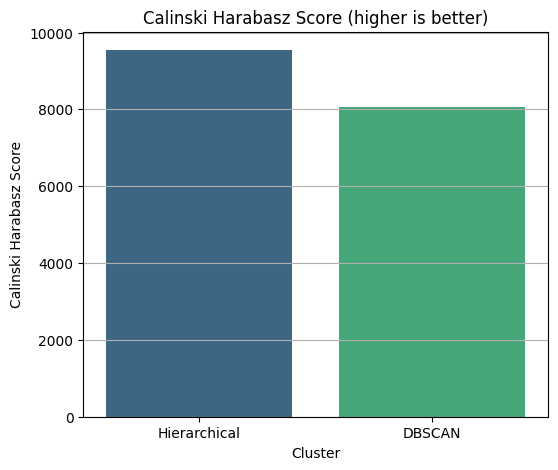

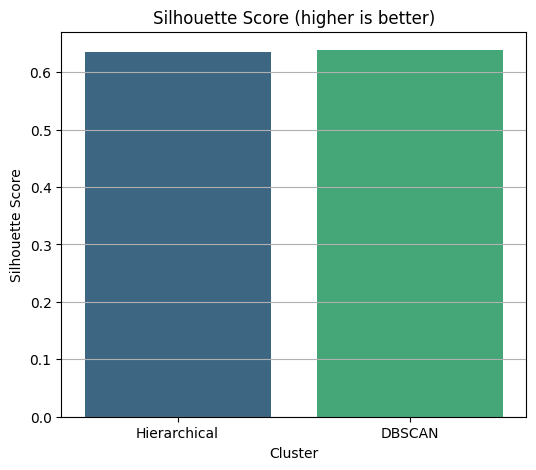

In [338]:
# barplot  davies_dbscan và davies_hirarchical , calinski_dbscan và calinski_hirarchical, ssilhouette_dbscan và ssilhouette_hirarchical vào 3 plot khác nhau

# Tạo dữ liệu cho biểu đồ
davies_scores = [davies_hierarchical, davies_dbscan]
calinski_scores = [calinski_hierarchical, calinski_dbscan]
silhouette_scores = [ssilhouette_hierarchical, ssilhouette_dbscan]

# Tạo tên cho các cụm
cluster_names = ['Hierarchical', 'DBSCAN']

# Tạo dataframe từ dữ liệu
davies_df = pd.DataFrame({'Cluster': cluster_names, 'Davies Bouldin Score': davies_scores})
calinski_df = pd.DataFrame({'Cluster': cluster_names, 'Calinski Harabasz Score': calinski_scores})
silhouette_df = pd.DataFrame({'Cluster': cluster_names, 'Silhouette Score': silhouette_scores})

# Vẽ biểu đồ
plt.figure(figsize=(6, 5))
sns.barplot(data=davies_df, x='Cluster', y='Davies Bouldin Score', palette='viridis', hue='Cluster')
plt.title('Davies Bouldin Score (lower is better)')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(6, 5))
sns.barplot(data=calinski_df, x='Cluster', y='Calinski Harabasz Score', palette='viridis', hue='Cluster')
plt.title('Calinski Harabasz Score (higher is better)')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(6, 5))
sns.barplot(data=silhouette_df, x='Cluster', y='Silhouette Score', palette='viridis', hue='Cluster')
plt.title('Silhouette Score (higher is better)')
plt.grid(axis='y')
plt.show()


``Nhận xét``:
- Cả 2 phương pháp phân cụm **Hierarchical Clustering** và **DBSCAN** đều cho ra các cụm có các tính chất khác nhau khi dùng các tham số đầu vào của mô hình một cách thích hợp
- Cả 2 phương pháp đều hỗ trợ phân cụm dữ liệu mà không cần xác định trước số cụm
- **Hierarchical Clustering** mất thời gian tính toán trên tập dữ liệu lớn nhưng cho ra kết quả phân cụm thể hiển tốt mỗi quan hệ giữa các cụm. Trong khi **DBSCAN** có thể xử lý các điểm nhiễu hiệu quả hơn nhưng khó khăn trong xử lý dữ liệu có nhiều điểm lân cận

``Kết luận``:
- Lựa chọn phương pháp **Hierarchical Clustering** để phân cụm dữ liệu
- Các cụm thu được:
    + Cụm 0: Là Thủ môn, cao, lớn tuổi, tactical cao, chân phải|số ít chân trái hoặc cả 2 chân, giá trị trung bình thấp
    + Cụm 1: Là Tiền đạo/Hậu vệ, attacking|technical|creativity cao, defending|tactical thấp, thuận 2 chân, lớn tuổi, giá trị trung bình thấp, giải đấu nhỏ
    + Cụm 2: Là Tiền vệ, hay ra sân, giải đấu lớn, defending|tactical khá cao, chân phải, giá trị trung bình cao
    + Cụm 3: Là Hậu vệ, khá lớn tuổi, hay ra sân, defending|tactical trung bình cao, giải đấu lớn,chân phải, giá trị trung bình cao
    + Cụm 4: Là Tiền đạo, attacking|technical|creativity trung bình cao, chân phải, giá trị cao
    + Cụm 5: Là Hậu vệ, trẻ, hay ra sân, attacking|technical|creativity trung bình cao, giải đấu lớn, chân trái, giá trị trunh bình cao
    + Cụm 6: Là Tiền vệ, hay ra sân, giải đấu lớn, attacking|technical|creativity trung bình, chân trái, giá trị trung bình cao
    + Cụm 7: Là Tiền đạo, attacking|technical|creativity trung bình cao, chân trái, giá trị trung bình
    + Cụm 8: Là Tiền vệ, ít ra sân, attacking|technical|creativity trung bình, giải đấu nhỏ, thuận 2 chân, giá trị thấp